# Autodobson recalibration

The purpose of this notebook is to show experimentation anwith different models for calibrating zenith Dobson measurements to direct sun Dobson measurements.

Data notes:
* The autoDobson is '073E', the manual Dobson is the '031E'.
* The type column for the autoDobson always says it is cloudy.
* The type column for the manual Dobson gives the cloud type by the 2nd digit.
* Measurements are contemporary if they are within a day.
* L0 values may be able to explain the differences between the instruments. If they do not, maybe we need to fit our own L0 values.
* There are some anomalies in the data, where the measurement values change very quickly, or produce unrealistic ozone values.

The full formula for calculating ozone values from pairs of spectrometer measurements is:

$$X_{12} = \frac{(N_1-N_2) - (pressure term) - (aerosol term)}{((\alpha-\alpha')_1-(\alpha-\alpha')_2)\mu}$$
From [this manual](http://www.o3soft.eu/dobsonweb/messages/revisedNo6NewFigsA.pdf) page 7. The aerosol term is assumed equal to zero, so it is only the intensity measurements, $\mu$ and the pressure that matter.

Fundamentally, we will be fitting the zenith measurements to the ozone values calculated from the direct sun measurements. Therefore, I think it's instructive to fit a model to the direct sun measurements first: I think that gives a benchmark for how good the zenith angle model can be.

I'm not 100% sure if the values in the original dataset are 'L' or 'I' values in the terminology of the manual. I've proceeded as if they are 'L', i.e. log intensity. I don't think I'm entirely consistent about when I write L or N.


## Data import and cleaning

First, we import some external libraries that will be used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from pathlib import Path
from pprint import pprint
from copy import deepcopy
import operator

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
)
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor

import seaborn as sns
from tqdm.notebook import tqdm

import itertools
import functools


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, max_error

Now we read in the data.
The data were originally supplied as .xlsx files,
but these are much slower to open than .csv files. Therefore, for fast experimentation purposes, it is useful to save the data as .csv after it has been read from the original .xlsx

*The parse_dates and dayfirst arguments are important. Pandas might assume American date styles for some of the dates if you aren't explicit! It will not warn you that it has done so.*

In [3]:
# Read the data
if (
    Path("data/Z6_Dataframe_zenith.csv").is_file()
    and Path("data/Z6_Dataframe_direct.csv").is_file()
):
    # Generally it will read faster from a csv than xlsx,
    # so I find it useful when testing to do it this way.
    df_zenith = pd.read_csv(
        "data/Z6_Dataframe_zenith.csv", parse_dates=True, dayfirst=True
    )
    df_direct = pd.read_csv(
        "data/Z6_Dataframe_direct.csv", parse_dates=True, dayfirst=True
    )
    print("hello")
else:
    df_zenith = pd.read_excel("data/Z6_Dataframe.xlsx", parse_dates=True, sheet_name=0)
    df_direct = pd.read_excel("data/Z6_Dataframe.xlsx", parse_dates=True, sheet_name=1)

    df_zenith.to_csv("data/Z6_Dataframe_zenith.csv")
    df_direct.to_csv("data/Z6_Dataframe_direct.csv")
print(df_zenith.dt)

hello
0        2012-02-04 15:46:00
1        2012-02-04 17:42:30
2        2012-02-05 12:45:30
3        2012-02-05 13:48:30
4        2012-02-05 14:48:00
                ...         
94373    2020-10-26 00:35:00
94374    2020-10-26 00:40:00
94375    2020-10-26 00:45:00
94376    2020-10-26 00:50:00
94377    2020-10-26 00:55:00
Name: dt, Length: 94378, dtype: object


In [4]:
# If the dates have not been parsed for some reason, they will have obj type instead of datetime type.
# This check is probably not necessary anymore, it was put in when we were debugging an issue with the dates.
# There is no harm in leaving it in.
if df_zenith.dt.dtype == "O":
    df_zenith["dt"] = pd.to_datetime(df_zenith.dt, dayfirst=True)

if df_direct.dt.dtype == "O":
    df_direct["dt"] = pd.to_datetime(df_direct.dt, dayfirst=True)

In [5]:
# The constants file was reformatted a bit from the file originally provided to me,
# but this should be consistent with what you have.
if Path("data/Z6_Dataframe_constants.csv").is_file():
    df_constants = pd.read_csv("data/Z6_Dataframe_constants.csv")
else:
    df_constants = pd.read_excel("data/Z6_Dataframe.xlsx", sheet_name=4)
    df_constants.to_csv("data/Z6_Dataframe_constants.csv")
droplist = []
for col in df_constants.columns:
    if "Unnamed:" in col:
        droplist.append(col)

df_constants = df_constants.drop(droplist, axis=1)
df_constants

,Year,Lo (A),Lo (C),Lo (D),Lat,Long,ID
0,2011,-0.030,-0.010,-0.010,-75.61,-26.21,031E
1,2012,-0.020,-0.010,-0.010,-75.61,-26.21,031E
2,2013,-0.020,-0.010,-0.010,-75.61,-26.22,031E
3,2014,-0.020,-0.010,-0.010,-75.61,-26.24,031E
4,2015,-0.020,-0.010,-0.010,-75.61,-26.25,031E
5,2016,-0.025,-0.010,-0.010,-75.61,-26.27,031E
6,2017,-0.022,-0.013,-0.011,-75.57,-25.47,031E
7,2018,-0.030,-0.020,-0.025,-75.57,-25.47,031E
8,2019,-0.040,-0.030,-0.030,-75.57,-25.49,031E
9,2017,-0.025,-0.016,-0.013,NaN,NaN,073E


In [6]:
# Remove annoying whitespace from column names. Tends to happen with excel files.
df_zenith = df_zenith.rename(columns=lambda x: x.strip())
df_direct = df_direct.rename(columns=lambda x: x.strip())
df_constants = df_constants.rename(columns=lambda x: x.strip())

In [7]:
# Back up the uncalibrated values.
# We will overwrite with L0 subtracted values.
for band in ["A", "C", "D"]:
    df_zenith[f"L({band})_uncalib"] = df_zenith[f"L({band})"]

In [8]:
# Apply the S calibration
for [Dobson, year], df in df_zenith.assign(year=df_zenith.dt.dt.year).groupby(
    ["Dobson", "year"]
):
    print(Dobson, year)
    for band in ["A", "C", "D"]:
        constant = df_constants[
            (df_constants.ID == Dobson) & (df_constants.Year == year)
        ][f"Lo ({band})"]
        try:
            constant = constant.item()
        except:
            print("\t", band, "\tNo calib constant for this year/band")
            constant = 0
        print("\t", band, "\t", constant)
        df_zenith.loc[df.index, f"L({band})"] = (
            df_zenith.loc[df.index, f"L({band})_uncalib"] + constant
        )

031E 2012
	 A 	 -0.02
	 C 	 -0.01
	 D 	 -0.01
031E 2013
	 A 	 -0.02
	 C 	 -0.01
	 D 	 -0.01
031E 2014
	 A 	 -0.02
	 C 	 -0.01
	 D 	 -0.01
031E 2015
	 A 	 -0.02
	 C 	 -0.01
	 D 	 -0.01
031E 2016
	 A 	 -0.025
	 C 	 -0.01
	 D 	 -0.01
031E 2017
	 A 	 -0.022
	 C 	 -0.013
	 D 	 -0.011
031E 2018
	 A 	 -0.03
	 C 	 -0.02
	 D 	 -0.025
031E 2019
	 A 	 -0.04
	 C 	 -0.03
	 D 	 -0.03
031E 2020
	 A 	No calib constant for this year/band
	 A 	 0
	 C 	No calib constant for this year/band
	 C 	 0
	 D 	No calib constant for this year/band
	 D 	 0
073E 2017
	 A 	 -0.025
	 C 	 -0.016
	 D 	 -0.013
073E 2018
	 A 	 -0.18
	 C 	 -0.11
	 D 	 -0.055
073E 2019
	 A 	 -0.18
	 C 	 -0.11
	 D 	 -0.055
073E 2020
	 A 	 -0.18
	 C 	 -0.11
	 D 	 -0.055


In [9]:
def get_mu(zenith):

    """
    Calculate mu value, using station and sun information.

    More or less copypasted from https://gitlab.data.bas.ac.uk/joson/autodobson/-/blob/master/autodobson/station.py
    """

    earth_radius = 6378137
    r = 6
    SZA = np.deg2rad(zenith)
    lat = -75.57
    rho = 0.9983271 + 1.6764e-3 * np.cos(2 * lat) * 35e-6 * np.cos(4 * lat)
    R = rho * earth_radius
    h = 26000 - (abs(lat) * 100)
    mu = (R + h) / np.sqrt(np.square(R + h) - np.square(R + r) * np.square(np.sin(SZA)))
    return mu

In [10]:
# Parse clearsky / cloudy flag
df_zenith["cloud"] = df_zenith.type.astype("str").str[-1]

# The cloud state is unknown for autodobson measurements
df_zenith.loc[df_zenith.Dobson == "073E", "cloud"] = "-1"

df_zenith["mu"] = get_mu(df_zenith.zenith_angle)

# Extra variables that I find useful
# Not all of these will end up being used in the final model.
assign_extras = lambda df: df.assign(
    cosSZA=np.cos(np.deg2rad(df.zenith_angle)),
    month=df.dt.dt.month,
    year=df.dt.dt.year,
    D073E=df.Dobson == "073E",  # onehot encoding of Dobson ID
    D031E=df.Dobson == "031E",  # onehot encoding of Dobson ID
    n1C_m_n2C=df["L1(C)"] - df["L2(C)"],
    n1D_m_n2D=df["L1(D)"] - df["L2(D)"],
    n1A_m_n2A=df["L1(A)"] - df["L2(A)"],
    nC_m_nD=(df["L(C)"] - df["L(D)"]),
    nA_m_nD=(df["L(A)"] - df["L(D)"]),
    nC_o_nD=(df["L(C)"] / df["L(D)"]),
    nA_o_nD=(df["L(A)"] / df["L(D)"]),
    secSZA=1 / np.cos(np.deg2rad(df.zenith_angle)),
    nA_m_nD_o_mu=(df["L(A)"] - df["L(D)"]) / df.mu,
    nC_m_nD_o_mu=(df["L(C)"] - df["L(D)"]) / df.mu,
    invmu=1 / df.mu,
)

df_direct = assign_extras(df_direct)
df_zenith = assign_extras(df_zenith)

In [11]:
# How many measurements for each spectrometer each year?
df_zenith.groupby("year").Dobson.value_counts()

year  Dobson
2012  031E        983
2013  031E       1092
2014  031E       1685
2015  031E       1602
2016  031E       1436
2017  031E        582
      073E          5
2018  031E        765
      073E         12
2019  073E      53062
      031E        552
2020  073E      32398
      031E        204
Name: Dobson, dtype: int64

In [12]:
# 073E has only a few measurements in 2017-2018, so I will throw them out.
# In the past, I've found that almost all these measurements were anomalous.
# It could just be that the calibration constants are a long way off.
df_zenith = df_zenith[(df_zenith.Dobson != "073E") | (df_zenith.year >= 2019)]

In [13]:
# There are some duplicated datetimes in the direct sun dataset.
# This causes problems when you try to associate zenith
# measurements with its nearest direct sun measurement.
df_direct.loc[df_direct.dt.duplicated()]

,Unnamed: 0,dt,type1,type2,Dobson,Lat,Lon,mu,zenith_angle,100hPa T,...,n1D_m_n2D,n1A_m_n2A,nC_m_nD,nA_m_nD,nC_o_nD,nA_o_nD,secSZA,nA_m_nD_o_mu,nC_m_nD_o_mu,invmu
2385,2385,2016-11-06 17:53:00,1,0,031E,-75.61,-26.2709,2.668,68.44,199.60330,...,-0.00738,-0.0046,NaN,0.73700,NaN,2.599809,2.721271,0.276237,NaN,0.374813
2594,2594,2017-01-27 13:41:00,1,0,031E,-75.61,-26.2709,1.839,57.34,229.72545,...,0.00000,0.0000,0.84499,0.75818,3.198777,2.972886,1.853044,0.412278,0.459483,0.543774


In [14]:
# As a result I drop duplicated datetimes in both datasets.
df_direct = df_direct.drop_duplicates("dt")
df_zenith = df_zenith.drop_duplicates("dt")

## Benchmarking
How well can we do at fitting a model to the direct sun measurements? We shouldn't expect to do better with the zenith data!

Based on the formula for two wavelength measurements, we should be able to reproduce the ozone measurement with N1 - N2, mu, and the pressure.
I haven't been provided with the pressure, so let's see how it does.

A linear regression will give a formula like $X_{12} = c+(N_1-N_2)*m1+\mu*m2$, which clearly does not have the same structure as the true formula!

In [15]:
sample_size = 1000

for wl in ("AD", "CD"):
    target = f"OZ{wl}"
    variables = [f"n{wl[0]}_m_n{wl[1]}_o_mu"]
    model = LinearRegression()

    # Get rid of NaN values
    df_sample = df_direct[[*variables, target]].dropna().sample(sample_size)
    X = df_sample[variables]
    y = df_sample[target]

    # Make a train/test split
    index_train, index_test = train_test_split(
        df_sample.index,
        test_size=0.5,
    )

    # Train the model
    model.fit(X.loc[index_train], y.loc[index_train])

    # Predictions for evaluation
    pred_train = model.predict(X.loc[index_train])
    pred_test = model.predict(X.loc[index_test])

    # How well did it do?
    result = {}
    result["wl"] = wl
    result["model_type"] = model.__repr__()
    result["R2_train"] = model.score(X.loc[index_train], y.loc[index_train])
    result["R2_test"] = model.score(X.loc[index_test], y.loc[index_test])
    result["rmse_train"] = mean_squared_error(
        y.loc[index_train], pred_train, squared=False
    )
    result["rmse_test"] = mean_squared_error(
        y.loc[index_test], pred_test, squared=False
    )

    pprint(result)

{'R2_test': 0.9995743016410641,
 'R2_train': 0.9994751052088592,
 'model_type': 'LinearRegression()',
 'rmse_test': 1.0353748685834745,
 'rmse_train': 1.178255576815863,
 'wl': 'AD'}
{'R2_test': 0.3473256305261093,
 'R2_train': 0.3756003893337262,
 'model_type': 'LinearRegression()',
 'rmse_test': 46.38063869871227,
 'rmse_train': 45.420013329543416,
 'wl': 'CD'}


{'R2_test': 0.9994096929087541,
 'R2_train': 0.9994763529805244,
 'model_type': 'LinearRegression()',
 'rmse_test': 1.16067464662822,
 'rmse_train': 1.139117586189083,
 'wl': 'AD'}
{'R2_test': 0.30184962988322595,
 'R2_train': 0.31232093457749965,
 'model_type': 'LinearRegression()',
 'rmse_test': 45.586960983208854,
 'rmse_train': 47.37591742593135,
 'wl': 'CD'}


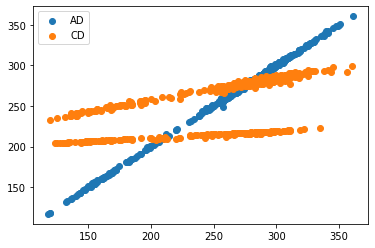

In [16]:
sample_size = 1000

for wl in ("AD", "CD"):
    target = f"OZ{wl}"
    variables = [f"n{wl[0]}_m_n{wl[1]}_o_mu"]
    model = LinearRegression()

    # Get rid of NaN values
    df_sample = df_direct[[*variables, target]].dropna().sample(sample_size)
    X = df_sample[variables]
    y = df_sample[target]

    # Make a train/test split
    index_train, index_test = train_test_split(
        df_sample.index,
        test_size=0.5,
    )

    # Train the model
    model.fit(X.loc[index_train], y.loc[index_train])

    # Predictions for evaluation
    pred_train = model.predict(X.loc[index_train])
    pred_test = model.predict(X.loc[index_test])

    # How well did it do?
    result = {}
    result["wl"] = wl
    result["model_type"] = model.__repr__()
    result["R2_train"] = model.score(X.loc[index_train], y.loc[index_train])
    result["R2_test"] = model.score(X.loc[index_test], y.loc[index_test])
    result["rmse_train"] = mean_squared_error(
        y.loc[index_train], pred_train, squared=False
    )
    result["rmse_test"] = mean_squared_error(
        y.loc[index_test], pred_test, squared=False
    )

    plt.scatter(y.loc[index_train], pred_train, label=wl)

    pprint(result)
plt.legend()

In [17]:
# It's not multi instruments
df_direct.Dobson.value_counts()

031E    3388
Name: Dobson, dtype: int64

{'R2_test': 0.8566406786197386,
 'R2_train': 0.8892261549895247,
 'model_type': 'LinearRegression()',
 'npoints': 993,
 'rmse_test': 18.47656804385638,
 'rmse_train': 16.922125283705856,
 'wl': 'CD'}
{'R2_test': 0.33629211911771795,
 'R2_train': 0.3846868452103088,
 'model_type': 'LinearRegression()',
 'npoints': 695,
 'rmse_test': 47.199744232236625,
 'rmse_train': 45.18656768578132,
 'wl': 'CD'}
{'R2_test': 0.9995709043754288,
 'R2_train': 0.9995527061279137,
 'model_type': 'LinearRegression()',
 'npoints': 987,
 'rmse_test': 1.045262151511999,
 'rmse_train': 1.0631339142079428,
 'wl': 'AD'}
{'R2_test': 0.9992872518616343,
 'R2_train': 0.9990033049283049,
 'model_type': 'LinearRegression()',
 'npoints': 12,
 'rmse_test': 1.175969653445304,
 'rmse_train': 1.1631524321471496,
 'wl': 'AD'}


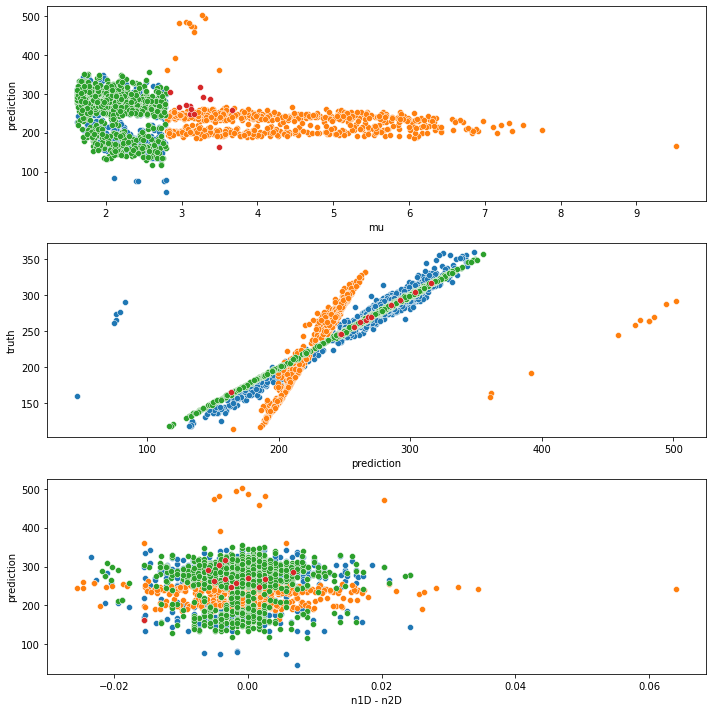

In [18]:
# sample_size = 1000
fig, ax = plt.subplots(3, figsize=(10, 10))

for wl in ("CD", "AD"):
    for mu_cut_op in (operator.le, operator.gt):
        mu_cut = lambda _df: _df[mu_cut_op(_df.mu, 2.8)]

        target = f"OZ{wl}"
        variables = [f"n{wl[0]}_m_n{wl[1]}_o_mu"]
        tags = ["Dobson", "year", "mu", "zenith_angle", "n1D_m_n2D", "n1C_m_n2C"]
        model = LinearRegression()

        # Get rid of NaN values
        df_sample = df_direct.pipe(mu_cut)[[*variables, *tags, target]].dropna()
        if 0 in df_sample.shape:
            continue
        # df_sample = df_sample.sample(sample_size)
        X = df_sample[variables]
        y = df_sample[target]

        # Make a train/test split
        index_train, index_test = train_test_split(
            df_sample.index,
            test_size=0.5,
        )

        # Train the model
        model.fit(X.loc[index_train], y.loc[index_train])

        # Predictions for evaluation
        pred_train = model.predict(X.loc[index_train])
        pred_test = model.predict(X.loc[index_test])

        # How well did it do?
        result = {}
        result["wl"] = wl
        result["npoints"] = index_train.shape[0]
        result["model_type"] = model.__repr__()
        result["R2_train"] = model.score(X.loc[index_train], y.loc[index_train])
        result["R2_test"] = model.score(X.loc[index_test], y.loc[index_test])
        result["rmse_train"] = mean_squared_error(
            y.loc[index_train], pred_train, squared=False
        )
        result["rmse_test"] = mean_squared_error(
            y.loc[index_test], pred_test, squared=False
        )

        sns.scatterplot(y=pred_train, x=df_sample.loc[index_train].mu, ax=ax[0])
        ax[0].set_xlabel("mu")
        ax[0].set_ylabel("prediction")

        sns.scatterplot(
            x=pred_train,
            y=y.loc[index_train],
            ax=ax[1],
            #             hue=df_sample.loc[index_train].year
        )
        ax[1].set_xlabel("prediction")
        ax[1].set_ylabel("truth")

        sns.scatterplot(
            x=df_sample.loc[index_train].n1D_m_n2D,
            y=pred_train,
            ax=ax[2],
            #             hue=df_sample.loc[index_train].year
        )
        ax[2].set_xlabel("n1D - n2D")
        ax[2].set_ylabel("prediction")

        pprint(result)
plt.tight_layout()

Wow, there is a pretty big difference between the behvaiour of the wavelength pairs!
Remember, this is with the direct sun measurements.
CD does very badly. Maybe this is because the pressure term is large for the CD pair, perhaps there is a bigger difference in the Rayleigh scattering wavelengths?

There is not necessarily anything wrong with the measurements, it could just be that we need the pressure data or something...

No, it's because there are two different instruments, or two different calibrations?

No, it's because the relationship is assumed to be different at different mu values.
The split seems to be at mu=2.8.
There are still some anomalous values even after this. I guess there is some subtlety I haven't managed to find in the autodobson repo.

My assumption is that we won't fit the zenith measurements to the direct sun measurements better than this.

## Interpolation
In order to fit the zenith measurements to the ozone values from the direct sun measurements, we first need to interpolate the ozone values for the zenith measurements.

* We can try out different methods of interpolation.
* We can exclude zenith measurements where there is not a direct sun measurement near enough in time later, using the 'tdiff_' variables.
* I will also try excluding values from the interpolation based on the anomaly detection above.
* I will also try smoothing out rather than assuming that every movement in the direct sun measurement is meaningful.

In [19]:
# Now let's assign ozone values from the nearest direct sun measurement to each zenith measurement.
# Note that we will later exclude those where the nearest measurement isn't close enough in time.
# You could choose a different interpolation method, e.g. linear
# NB, it's better to do this after removing anomalies from the direct sun dataset.
df_zenith = df_zenith.reset_index()
df_direct = df_direct.reset_index()
set_time = pd.to_datetime("2000-01-01 00:00:00")

interp_methods = ["nearest", "linear"]
for wl in ["CD", "AD"]:
    var = f"OZ{wl}"
    df_source = df_direct[["dt", var]].dropna()
    for method in interp_methods:
        df_zenith[f"{var}_{method}"] = interpolate.interp1d(
            (df_source.dt - set_time).dt.total_seconds(),
            df_source[var].values,
            method,
            fill_value=np.nan,
            bounds_error=False,
        )((df_zenith.dt - set_time).dt.total_seconds())

# Daily smoothing
interp_methods = ["linear", "cubic"]
for wl in ["CD", "AD"]:
    var = f"OZ{wl}"
    df_source = df_direct[["dt", var]].dropna()
    df_source = df_source.set_index("dt").resample("D").mean().dropna().reset_index()
    for method in interp_methods:
        df_zenith[f"{var}_{method}_smooth"] = interpolate.interp1d(
            (df_source.dt - set_time).dt.total_seconds(),
            df_source[var].values,
            method,
            fill_value=np.nan,
            bounds_error=False,
        )((df_zenith.dt - set_time).dt.total_seconds())


# Weekly smoothing
interp_methods = ["linear", "cubic"]
for wl in ["CD", "AD"]:
    var = f"OZ{wl}"
    df_source = df_direct[["dt", var]].dropna()
    df_source = df_source.set_index("dt").resample("W").mean().dropna().reset_index()
    for method in interp_methods:
        df_zenith[f"{var}_{method}_wsmooth"] = interpolate.interp1d(
            (df_source.dt - set_time).dt.total_seconds(),
            df_source[var].values,
            method,
            fill_value=np.nan,
            bounds_error=False,
        )((df_zenith.dt - set_time).dt.total_seconds())

In [20]:
df_zenith = df_zenith.set_index("dt")
df_direct = df_direct.set_index("dt")

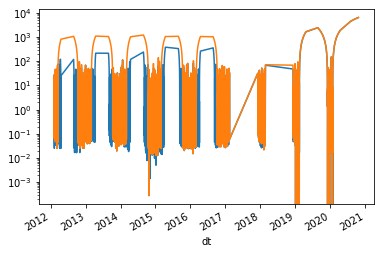

In [21]:
# Get the time between
# each zenith measurement, and the closest direct sun measurement.
# I think this is in nanoseconds by default, I convert to hours.

for wl in ["CD", "AD"]:
    var = f"OZ{wl}"
    df_zenith[f"tdiff_{var}"] = (
        np.abs(
            (
                df_direct[(~df_direct[var].isna())].index.values.reshape((-1, 1))
                - df_zenith.index.values.reshape(1, -1)
            )
        )
        .min(0)
        .astype("timedelta64[s]")
        .astype(np.int32)
        / 3600  # to hours
    )

# Plot the time differences as a sanity check.
(df_zenith["tdiff_OZCD"]).plot()
(df_zenith["tdiff_OZAD"]).plot()
plt.yscale("log")

<AxesSubplot:xlabel='dt'>

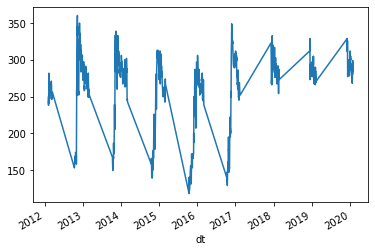

In [22]:
df_zenith.OZAD_linear.plot()

<AxesSubplot:xlabel='dt'>

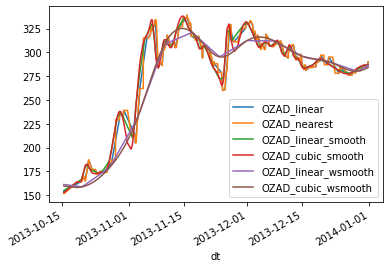

In [23]:
df_zenith[df_zenith.tdiff_OZAD < 24].loc["2013-10-15":"2013-12"][
    [
        "OZAD_linear",
        "OZAD_nearest",
        "OZAD_linear_smooth",
        "OZAD_cubic_smooth",
        "OZAD_linear_wsmooth",
        "OZAD_cubic_wsmooth",
    ]
].plot()

I think `linear_smooth` probably makes the most sense (i.e. interpolated from the daily mean). Using weekly smoothing would make sense if we think the daily movements are random errors, which they don't seem to be.

It's worth noting at this point that putting a limit on time difference implicitly also affects mu.
If you want the model to be accurate at a range of values of mu, the time limit should be about 24 hours.

<AxesSubplot:xlabel='tdiff_OZAD', ylabel='mu'>

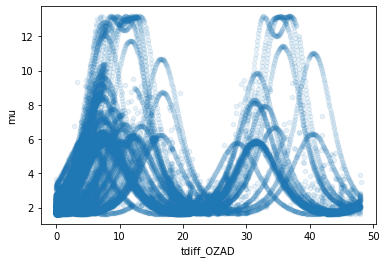

In [24]:
df_zenith[df_zenith.tdiff_OZAD < 48].plot.scatter("tdiff_OZAD", "mu", alpha=0.1)

## Is the data sufficient for the problem?
Summary:
* In order to do a straightforward regression based on synchronised measurements of direct and zenith measurements, there needs to be enough variation in the synchronised data to capture the relationship.
* For the manual dobson measurements with 031E, sampling goes back a number of years and sees a lot of different ozone values.
* For the autodobson zenith measurements with 073E, there is very little variation in the ozone value in the synchronised direct measurements. The relationship cannot be inferred from this data, regardless of the regression method used.

First, let's look at the manual zenith measurements.
LA_m_LD_o_mu is equivalent to the first term in calculation used in the direct sun measurements.
Note that these are made with the same instrument, so should have the same calibration constants.

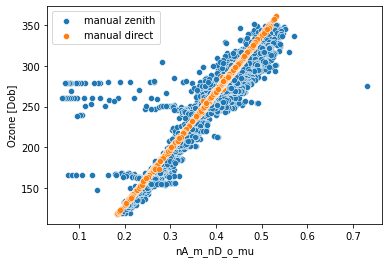

In [25]:
sns.scatterplot(
    data=df_zenith[~df_zenith.D073E][["OZAD_linear_smooth", "nA_m_nD_o_mu"]],
    x="nA_m_nD_o_mu",
    y="OZAD_linear_smooth",
    label="manual zenith",
)
sns.scatterplot(
    data=df_direct[
        [
            "OZAD",
            "nA_m_nD_o_mu",
        ]
    ],
    x="nA_m_nD_o_mu",
    y="OZAD",
    label="manual direct",
)
plt.ylabel("Ozone [Dob]")
plt.legend()

A lot of those outliers get removed if you require that there is a direct measurement within 1 hour.
It looks like you actually get quite a few anomalies in just a few hours.

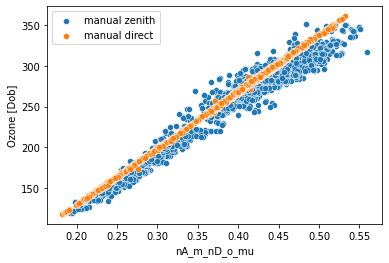

In [26]:
sns.scatterplot(
    data=df_zenith[(~df_zenith.D073E) & (df_zenith.tdiff_OZAD < 1)][
        ["OZAD_linear_smooth", "nA_m_nD_o_mu"]
    ],
    x="nA_m_nD_o_mu",
    y="OZAD_linear_smooth",
    label="manual zenith",
)
sns.scatterplot(
    data=df_direct[
        [
            "OZAD",
            "nA_m_nD_o_mu",
        ]
    ],
    x="nA_m_nD_o_mu",
    y="OZAD",
    label="manual direct",
)
plt.ylabel("Ozone [Dob]")
plt.legend()

Aside from a few outliers, the relationship between this key variable and and the ozone measurement is very similar in these two measurement datasets. In fact, you could basically calculate the zenith measurement in the same was as the direct measurement, maybe with some small corrections.

It is actually a bit more complicated when it comes to the CD data as there are two sets of calibration constants, but let's keep it simple for now.

Now let's look at the autodobson data. There is very little synchronised data in this case.

In [27]:
df_zenith[df_zenith.D073E].OZAD_linear.round(1).pipe(lambda s: (s.min(), s.max()))

(266.0, 329.0)

In [28]:
df_zenith[~df_zenith.D073E].OZAD_linear.round(1).pipe(lambda s: (s.min(), s.max()))

(118.0, 360.3)

The auto zenith measurements only sample ozone values between 267 and 329 Dob.
Whereas the manual measurements cover a much larger range.

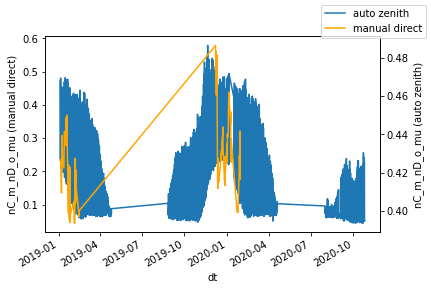

In [29]:
start_time, end_time = df_zenith[df_zenith.D073E].pipe(
    lambda _df: (_df.index.min(), _df.index.max())
)
fig, ax = plt.subplots()
ax1 = ax.twinx()
df_zenith[(df_zenith.D073E)].nA_m_nD_o_mu.dropna().plot(ax=ax, label="auto zenith")
df_direct.loc[start_time:end_time].nA_m_nD_o_mu.dropna().plot(
    ax=ax1, c="orange", label="manual direct"
)
ax1.set_ylabel("nC_m_nD_o_mu (auto zenith)")
ax.set_ylabel("nC_m_nD_o_mu (manual direct)")
fig.legend()

You have a very high sample rate and lots of noise in the autodobson data, but you don't have much genuine variation in the ozone values over that same period. The signal-to-noise ratio is low. I will explain what the 'noise' actually is later.


(I've put them on separate axes because the range of the values for the two instruments is a bit different.)

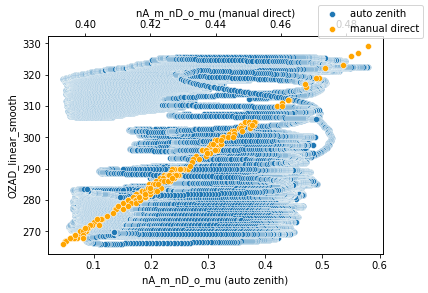

In [30]:
fig, ax = plt.subplots()
ax1 = ax.twiny()
sns.scatterplot(
    data=df_zenith[(df_zenith.D073E)][["OZAD_linear_smooth", "nA_m_nD_o_mu"]],
    x="nA_m_nD_o_mu",
    y="OZAD_linear_smooth",
    label="auto zenith",
    ax=ax,
    legend=False,
)
sns.scatterplot(
    data=df_direct.loc[start_time:end_time][
        [
            "OZAD",
            "nA_m_nD_o_mu",
        ]
    ],
    x="nA_m_nD_o_mu",
    y="OZAD",
    label="manual direct",
    ax=ax1,
    color="orange",
    legend=False,
)
ax.set_xlabel("nA_m_nD_o_mu (auto zenith)")
ax1.set_xlabel("nA_m_nD_o_mu (manual direct)")
plt.ylabel("Ozone [Dob]")
fig.legend()

It looks pretty crazy, and like you won't be able to get the relationship out of it.
The 'tracks' are because the ozone values for the auto zenith data are autocorrelated. Some of those values will not be reliable as they are interpolating values very far apart.

What does the relationship between ozone and nA_m_nD_o_mu look like if we select just the data that is synchronized?
I will select auto data only when there is a direct measurement within 24 hours.

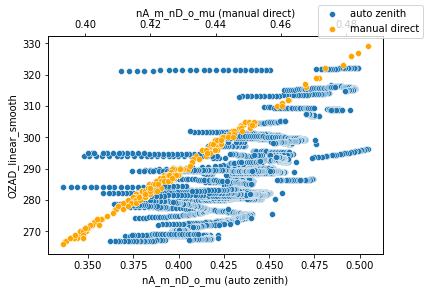

In [31]:
fig, ax = plt.subplots()
ax1 = ax.twiny()
sns.scatterplot(
    data=df_zenith[(df_zenith.D073E) & (df_zenith.tdiff_OZAD < 1)][
        ["OZAD_linear_smooth", "nA_m_nD_o_mu"]
    ],
    x="nA_m_nD_o_mu",
    y="OZAD_linear_smooth",
    label="auto zenith",
    ax=ax,
    legend=False,
)
sns.scatterplot(
    data=df_direct.loc[start_time:end_time][
        [
            "OZAD",
            "nA_m_nD_o_mu",
        ]
    ],
    x="nA_m_nD_o_mu",
    y="OZAD",
    label="manual direct",
    ax=ax1,
    color="orange",
    legend=False,
)
ax.set_xlabel("nA_m_nD_o_mu (auto zenith)")
ax1.set_xlabel("nA_m_nD_o_mu (manual direct)")
plt.ylabel("Ozone [Dob]")
fig.legend()

Maybe you can say the relationship is still there, but it's quite messy, there isn't much data, and the high sample rate obscures it slightly. The situation isn't really any different for the other interpolation methods.

Now I will try and get rid of the tracks by only taking the maximum value each day for the auto zenith data. In this case I set the time limit to 7 days.

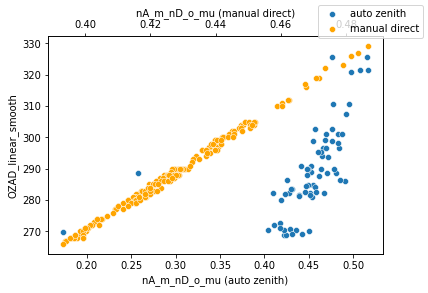

In [32]:
fig, ax = plt.subplots()
ax1 = ax.twiny()
sns.scatterplot(
    data=df_zenith[(df_zenith.D073E) & (df_zenith.tdiff_OZAD < 24)]
    .resample("D")
    .max()[
        [
            "OZAD_linear_smooth",
            "nA_m_nD_o_mu",
        ]
    ],
    x="nA_m_nD_o_mu",
    y="OZAD_linear_smooth",
    label="auto zenith",
    ax=ax,
    legend=False,
)
sns.scatterplot(
    data=df_direct.loc[start_time:end_time][
        [
            "OZAD",
            "nA_m_nD_o_mu",
        ]
    ],
    x="nA_m_nD_o_mu",
    y="OZAD",
    label="manual direct",
    ax=ax1,
    color="orange",
    legend=False,
)
ax.set_xlabel("nA_m_nD_o_mu (auto zenith)")
ax1.set_xlabel("nA_m_nD_o_mu (manual direct)")
plt.ylabel("Ozone [Dob]")
fig.legend()

Alternatively, we could look at a narrow slice of mu space.

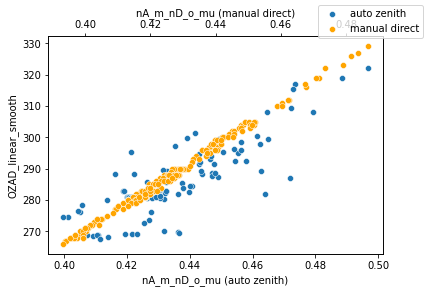

In [33]:
fig, ax = plt.subplots()
ax1 = ax.twiny()
sns.scatterplot(
    data=df_zenith[
        (df_zenith.D073E)
        & (df_zenith.tdiff_OZAD < 24)
        & (df_zenith.mu > 2)
        & (df_zenith.mu < 2.01)
    ][
        [
            "OZAD_linear_smooth",
            "nA_m_nD_o_mu",
        ]
    ],
    x="nA_m_nD_o_mu",
    y="OZAD_linear_smooth",
    label="auto zenith",
    ax=ax,
    legend=False,
)
sns.scatterplot(
    data=df_direct.loc[start_time:end_time][
        [
            "OZAD",
            "nA_m_nD_o_mu",
        ]
    ],
    x="nA_m_nD_o_mu",
    y="OZAD",
    label="manual direct",
    ax=ax1,
    color="orange",
    legend=False,
)
ax.set_xlabel("nA_m_nD_o_mu (auto zenith)")
ax1.set_xlabel("nA_m_nD_o_mu (manual direct)")
plt.ylabel("Ozone [Dob]")
fig.legend()

It doesn't have to be mu~2.

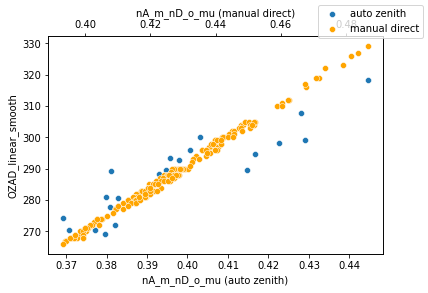

In [34]:
fig, ax = plt.subplots()
ax1 = ax.twiny()
sns.scatterplot(
    data=df_zenith[
        (df_zenith.D073E)
        & (df_zenith.tdiff_OZAD < 24)
        & (df_zenith.mu > 3)
        & (df_zenith.mu < 3.01)
    ][
        [
            "OZAD_linear_smooth",
            "nA_m_nD_o_mu",
        ]
    ],
    x="nA_m_nD_o_mu",
    y="OZAD_linear_smooth",
    label="auto zenith",
    ax=ax,
    legend=False,
)
sns.scatterplot(
    data=df_direct.loc[start_time:end_time][
        [
            "OZAD",
            "nA_m_nD_o_mu",
        ]
    ],
    x="nA_m_nD_o_mu",
    y="OZAD",
    label="manual direct",
    ax=ax1,
    color="orange",
    legend=False,
)
ax.set_xlabel("nA_m_nD_o_mu (auto zenith)")
ax1.set_xlabel("nA_m_nD_o_mu (manual direct)")
plt.ylabel("Ozone [Dob]")
fig.legend()

If we just look at the maximum value for each day, or a narrow slice of mu, the relationship becomes clearer. But, now we have a very small set of values to work with.
It's entirely possible that the regression will be able to pick up on the effect of mu.

We may be able to extract this relationship, but:
1. We won't be able to do a 'train-test split'. This might be ok if we are confident we know what the relationship should be.
2. We won't be able to properly assess how accurate the method is.
3. The relationship might vary with mu, but we won't be able to capture that because we are only taking one value per day.

## What does the 'noise' mean?
There is no atmospheric reason for ozone to vary symmetrically around midday.
However, all of the measured variables do vary symmetrically about midday.
This is true for the direct measurements and the zenith measurements, although the manual measurements have more gaps.

(Note I've cherrypicked this date range as it shows the effect well)

Text(0.5, 1.0, 'Manual direct')

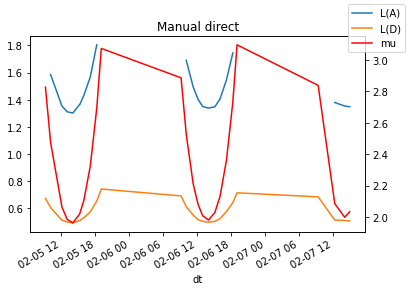

In [35]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
df_direct.loc["2019-02-05":"2019-02-07"][["L(A)", "L(D)"]].plot(ax=ax, legend=False)
df_direct.loc["2019-02-05":"2019-02-07"][["mu"]].plot(ax=ax1, c="r", legend=False)
fig.legend()
ax.set_title("Manual direct")

Text(0.5, 1.0, 'Auto zenith')

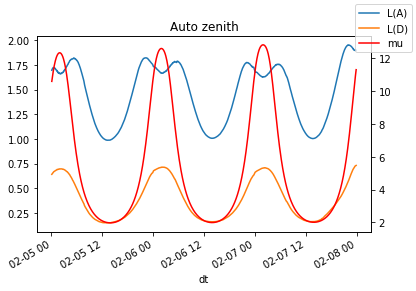

In [36]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
df_zenith[df_zenith.D073E].loc["2019-02-05":"2019-02-07"][["L(A)", "L(D)"]].plot(
    ax=ax, legend=False
)
df_zenith[df_zenith.D073E].loc["2019-02-05":"2019-02-07"][["mu"]].plot(
    ax=ax1, c="r", legend=False
)
fig.legend()
ax.set_title("Auto zenith")

The oscillation is very much present in the raw measurements. The calculation of ozone values then must be partly about removing this oscillation.

We can see that for the direct data, LA_m_LD_o_mu does not have the patterns of oscillation that L(A), L(D), and mu have individually.

Text(0.5, 1.0, 'Manual direct')

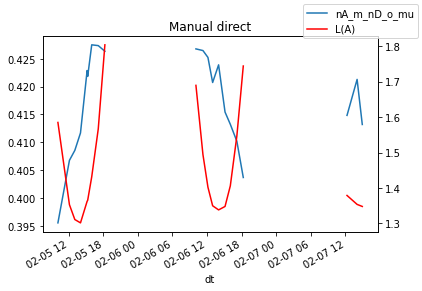

In [37]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
df_direct.loc["2019-02-05":"2019-02-07"][["nA_m_nD_o_mu"]].plot(ax=ax, legend=False)
df_direct.loc["2019-02-05":"2019-02-07"][["L(A)"]].plot(ax=ax1, c="r", legend=False)
fig.legend()
ax.set_title("Manual direct")

On the other hand, the zenith measurements do still have oscillations in nA_m_nD_o_mu.
These oscillations are in sync with 1/mu.
It is true for both the manual and auto zenith measurements.

It could be the case that there is a mu dependent calibration constant applied to the direct data but not to the zenith data? I'm not sure what calibration steps have been applied to the datasets I'm working from.

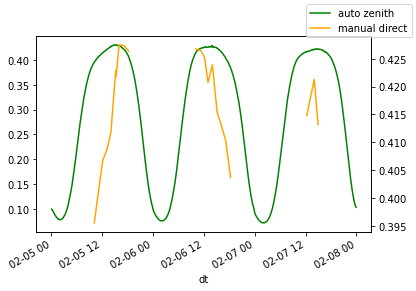

In [38]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
df_zenith[df_zenith.D073E].loc["2019-02-05":"2019-02-07"]["nA_m_nD_o_mu"].plot(
    c="green", ax=ax, legend=False, label="auto zenith"
)
df_direct.loc["2019-02-05":"2019-02-07"]["nA_m_nD_o_mu"].plot(
    ax=ax1, legend=False, c="orange", label="manual direct"
)
fig.legend()

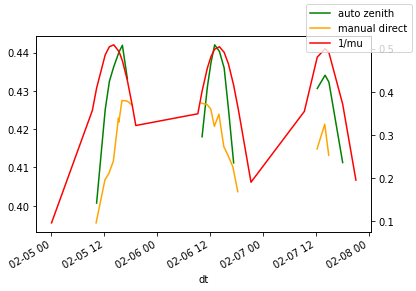

In [39]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
df_zenith[~df_zenith.D073E].loc["2019-02-05":"2019-02-07"]["nA_m_nD_o_mu"].plot(
    c="green", ax=ax, legend=False, label="auto zenith"
)
df_zenith[~df_zenith.D073E].loc["2019-02-05":"2019-02-07"].pipe(
    lambda _df: 1 / _df.mu
).plot(c="r", ax=ax1, legend=False, label="1/mu")
df_direct.loc["2019-02-05":"2019-02-07"]["nA_m_nD_o_mu"].plot(
    ax=ax, legend=False, c="orange", label="manual direct"
)
fig.legend()

If everything was well behaved, it should be possible to only calibrate nA_m_nD_o_mu and nC_m_nD_o_mu to be the sole predictor of ozone. But if you do so, you will find that there is oscillation.

Also, looking at the CD data instead of the AD data, the oscillations are still present in the direct data nC_m_nD_o_mu!
(Do not overinterpret the waves lining up perfectly on the y axis, they are on separate y axes. Really, the points at the bottom of the orange curve are sampled higher up the red curve.)

Text(0, 0.5, 'nC_m_nD_o_mu')

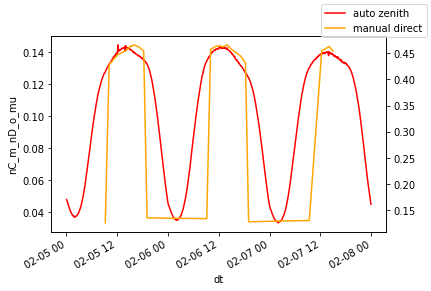

In [40]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
df_zenith[df_zenith.D073E].loc["2019-02-05":"2019-02-07"].nC_m_nD_o_mu.plot(
    ax=ax, c="r", label="auto zenith"
)
df_direct.loc["2019-02-05":"2019-02-07"].nC_m_nD_o_mu.plot(
    ax=ax1, c="orange", label="manual direct"
)
fig.legend()
ax.set_ylabel("nC_m_nD_o_mu")

But, if you look at the OZCD values, you see that this pattern is not present. This is definitely because there is some mu dependent calibration applied.

Text(0, 0.5, 'OZCD')

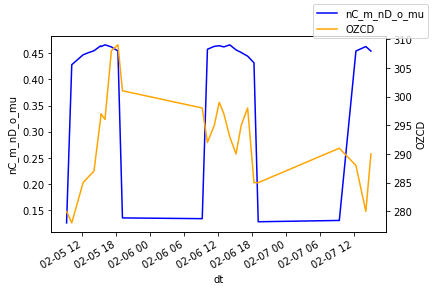

In [41]:
fig, ax = plt.subplots()
ax1 = ax.twinx()

df_direct.loc["2019-02-05":"2019-02-07"].nC_m_nD_o_mu.plot(
    ax=ax, c="b", label="nC_m_nD_o_mu"
)
df_direct.loc["2019-02-05":"2019-02-07"].OZCD.plot(ax=ax1, c="orange", label="OZCD")
fig.legend()
ax.set_ylabel("nC_m_nD_o_mu")
ax1.set_ylabel("OZCD")

The question we are really interested in is whether this leads to a systematic difference in the ozone values. This is something to come back to after fitting a model.

## Fitting models

Now I'm going to experiment with creating models to fit the zenith measurements to contemporary direct sun measurements.

* It is easy enough to calibrate the manual zenith data, as the sampling is good. If there is oscillation, it will not be very obvious because there aren't so many samples.
* We will see that applying the same approach to the autodobson data gives systematically biased results.
* I will explore a different approach to the autodobson data using a very reduced dataset.


Firstly, what if we only give the model the 'ideal' predictor, i.e. the one that would make the calculation most similar to the direct sun measurement?

In [42]:
# Train/validate/test split will be the same for all experiments.
# You need separate validation and test sets,
# or your model structure choice will be biased,
# leading to underestimation of the error in production.

test_size = 0.2
val_size = 0.2
random_state = 0

index_train, index_val = train_test_split(
    df_zenith.index, test_size=0.2, random_state=random_state
)


# For now, I will give it just the 'ideal' variable.
variable_dict = {
    "CD": [
        [
            "nC_m_nD_o_mu",
        ],
    ],
    "AD": [
        [
            "nA_m_nD_o_mu",
        ],
    ],
}

# Experiment with different interpolation methods
# interpolation_method_list = ["linear", "nearest", "cubic_smooth", "linear_smooth"]
interpolation_method_list = ["linear_smooth", "linear_wsmooth"]

# Experiment with placing limits on the time difference between
# the zenith measurement and the direct sun measurement.
timediff_limit_list = [24]  # [1, 2, 3, 4, 8, 12, 24]  # these are in hours

# Experiment with limiting the zenith angle range.
zenith_angle_limit_array = np.arange(60, 90, 2.5)

# Experiment with different model structures
model_structure_list = [
    # Dummy that just predicts the mean, for assessing performance.
    DummyRegressor(),
    # Standard linear regression
    make_pipeline(LinearRegression()),
]

results = []

# Loop over AD/CD
for wl, predictor_list in variable_dict.items():
    target = f"OZ{wl}"
    print(target)
    # How many models are we training?
    number_of_models = functools.reduce(
        operator.mul,
        map(
            len,
            [
                [True, False],
                predictor_list,
                timediff_limit_list,
                interpolation_method_list,
                model_structure_list,
                zenith_angle_limit_array,
            ],
        ),
        1,
    )

    # Loop over model configurations
    for (
        use_D073E,
        predictors,
        timediff_limit,
        interpolation_method,
        model,
        zenith_angle_limit,
    ) in tqdm(  # progress bar
        itertools.product(  # all combinations of model config
            [True, False],
            predictor_list,
            timediff_limit_list,
            interpolation_method_list,
            model_structure_list,
            zenith_angle_limit_array,
        ),
        total=number_of_models,
    ):

        # Set variable names
        target_variable = f"{target}_{interpolation_method}"
        variables = [target_variable, *predictors]

        # Subset zenith data to just variables of interest,
        # and select only data within a reasonable time of
        # the last direct measurement.
        # Also drop NaN values.
        df_train = df_zenith[
            (df_zenith[f"tdiff_{target}"] < timediff_limit)
            & (df_zenith.zenith_angle < zenith_angle_limit)
            & (np.isin(df_zenith.index, index_train))
            & (df_zenith.D073E == use_D073E)
        ][variables].dropna()

        df_val = df_zenith[
            (df_zenith[f"tdiff_{target}"] < timediff_limit)
            & (df_zenith.zenith_angle < zenith_angle_limit)
            & (np.isin(df_zenith.index, index_val))
            & (df_zenith.D073E == use_D073E)
        ][variables].dropna()

        X_train = df_train[predictors]
        y_train = df_train[target_variable]
        X_val = df_val[predictors]
        y_val = df_val[target_variable]

        # Train the model
        # print(model)
        model.fit(X_train, y_train)

        # Get the error score
        y_val_predict = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_val_predict, squared=False)
        maxe = max_error(y_val, y_val_predict)

        # Get the R^2 score
        r2 = model.score(X_val, y_val)

        # Save the results
        results.append(
            {
                "rmse": rmse,
                "standard_error": rmse / np.sqrt(df_val.shape[0]),
                "maxe": maxe,
                "r2": r2,
                "target": target,
                "D073E": use_D073E,
                "predictors": predictors,
                "set_size": df_train.shape[0],
                "val_size": df_val.shape[0],
                "timediff_limit": timediff_limit,
                "zenith_angle_limit": zenith_angle_limit,
                "interpolation_method": interpolation_method,
                "model": deepcopy(model),
                "model_str": str(model),
            }
        )

# We can now make a dataframe of our results...
df_results = pd.DataFrame(results)

OZCD


  0%|          | 0/96 [00:00<?, ?it/s]

OZAD


  0%|          | 0/96 [00:00<?, ?it/s]

In [43]:
df_results.groupby(["D073E", "target", "model_str",]).apply(
    lambda df: df.iloc[df["standard_error"].argmin()]
)[["rmse", "r2"]]

rmse  \
D073E target model_str                                                       
False OZAD   DummyRegressor()                                    47.073875   
             Pipeline(steps=[('linearregression', LinearRegr...  10.188789   
      OZCD   DummyRegressor()                                    54.259770   
             Pipeline(steps=[('linearregression', LinearRegr...  12.498363   
True  OZAD   DummyRegressor()                                    11.382955   
             Pipeline(steps=[('linearregression', LinearRegr...   7.248958   
      OZCD   DummyRegressor()                                     9.558336   
             Pipeline(steps=[('linearregression', LinearRegr...   9.197858   

                                                                       r2  
D073E target model_str                                                     
False OZAD   DummyRegressor()                                   -0.000187  
             Pipeline(steps=[('linearregression', LinearRegr...  0.943487  
      OZCD   DummyRegressor()                                   -0.000243  
             Pipeline(steps=[('linearregression', LinearRegr...  0.932598  
True  OZAD   DummyRegressor()                                   -0.002174  
             Pipeline(steps=[('linearregression', LinearRegr...  0.572117  
      OZCD   DummyRegressor()                                   -0.002290  
             Pipeline(steps=[('linearregression', LinearRegr...  0.071884

DummyRegressor just returns the mean as the prediction. I am just using it to put the RMSE in context.

Notice that for the autodobson data (D073E=True), the DummyRegressor RMSE is not that much worse than the LinearRegressor. The LinearRegressor is simply not finding a clear relationship between LC_m_LD_o_mu, or LA_m_LD_o_mu and the ozone value. This is because I've included all of the applicable data, which makes the autodobson very noisey!



In [44]:
df_best_models = df_results.groupby(
    [
        "D073E",
        "target",
    ]
).apply(lambda df: df.iloc[df["standard_error"].argmin()])
df_best_models[["model_str", "rmse", "r2"]]

model_str       rmse  \
D073E target                                                                 
False OZAD    Pipeline(steps=[('linearregression', LinearReg...  10.188789   
      OZCD    Pipeline(steps=[('linearregression', LinearReg...  12.498363   
True  OZAD    Pipeline(steps=[('linearregression', LinearReg...   7.248958   
      OZCD    Pipeline(steps=[('linearregression', LinearReg...   9.197858   

                    r2  
D073E target            
False OZAD    0.943487  
      OZCD    0.932598  
True  OZAD    0.572117  
      OZCD    0.071884

Now, let's give the model more variables to work with, and more freedom.
There are a lot more combinations of predictor variables and model types in this cell.

In [45]:
# Train/validate/test split will be the same for all experiments.
# You need separate validation and test sets,
# or your model structure choice will be biased,
# leading to underestimation of the error in production.

test_size = 0.2
val_size = 0.2
random_state = 0

index_train, index_val = train_test_split(
    df_zenith.index, test_size=0.2, random_state=random_state
)

variable_dict = {
    "CD": [
        [
            "nC_m_nD_o_mu",
        ],
        [
            "nC_m_nD_o_mu",
            "mu",
        ],
        ["nC_m_nD_o_mu", "L(C)"],
        ["nC_m_nD_o_mu", "L(D)"],
        ["nC_m_nD_o_mu", "mu", "L(C)"],
        ["nC_m_nD_o_mu", "mu", "L(D)"],
        ["nC_m_nD_o_mu", "mu", "L(D)", "L(C)"],
    ],
    "AD": [
        [
            "nA_m_nD_o_mu",
        ],
        ["nA_m_nD_o_mu", "mu"],
        ["nA_m_nD_o_mu", "L(A)"],
        ["nA_m_nD_o_mu", "L(D)"],
        ["nA_m_nD_o_mu", "mu", "L(A)"],
        ["nA_m_nD_o_mu", "mu", "L(D)"],
        ["nA_m_nD_o_mu", "mu", "L(D)", "L(A)"],
    ],
}

# Experiment with different interpolation methods
# interpolation_method_list = ["linear", "nearest", "cubic_smooth", "linear_smooth"]
interpolation_method_list = [
    "nearest",
    "linear",
    "linear_smooth",
    "linear_wsmooth",
    "cubic_smooth",
    "cubic_wsmooth",
]

# Experiment with placing limits on the time difference between
# the zenith measurement and the direct sun measurement.
# Restricting this will make the model fit better, but then you are implicitly limiting mu as well.
timediff_limit_list = [24]  # [1, 2, 3, 4, 8, 12, 24]  # these are in hours

# Experiment with limiting the zenith angle range.
# We don't actually want to reduce this range, because we want our predictions to be a good fit at all values of mu.
zenith_angle_limit_array = [90]  # np.arange(60, 90, 2.5)

# Experiment with different model structures
model_structure_list = [
    # Dummy that just predicts the mean, for assessing performance.
    #     make_pipeline(DummyRegressor()),
    # Standard linear regression
    make_pipeline(LinearRegression()),
    # Interaction terms only
    make_pipeline(
        PolynomialFeatures(interaction_only=True), StandardScaler(), LinearRegression()
    ),
    # Polynomial terms O(2)
    make_pipeline(PolynomialFeatures(2), StandardScaler(), LinearRegression()),
    # Polynomial terms O(3)
    make_pipeline(PolynomialFeatures(3), StandardScaler(), LinearRegression()),
    # Shallow artificial neural network - watch out this is comparatively slow to train and will certainly overfit.
    #     make_pipeline(StandardScaler(), MLPRegressor(max_iter=3000)),
]

results = []

# Loop over AD/CD
for wl, predictor_list in variable_dict.items():
    target = f"OZ{wl}"
    print(target)
    # How many models are we training?
    number_of_models = functools.reduce(
        operator.mul,
        map(
            len,
            [
                [True, False],
                predictor_list,
                timediff_limit_list,
                interpolation_method_list,
                model_structure_list,
                zenith_angle_limit_array,
            ],
        ),
        1,
    )

    # Loop over model configurations
    for (
        use_D073E,
        predictors,
        timediff_limit,
        interpolation_method,
        model,
        zenith_angle_limit,
    ) in tqdm(  # progress bar
        itertools.product(  # all combinations of model config
            [True, False],
            predictor_list,
            timediff_limit_list,
            interpolation_method_list,
            model_structure_list,
            zenith_angle_limit_array,
        ),
        total=number_of_models,
    ):

        # Set variable names
        target_variable = f"{target}_{interpolation_method}"
        variables = [target_variable, *predictors]

        # Subset zenith data to just variables of interest,
        # and select only data within a reasonable time of
        # the last direct measurement.
        # Also drop NaN values.
        df_train = df_zenith[
            (df_zenith[f"tdiff_{target}"] < timediff_limit)
            & (df_zenith.zenith_angle < zenith_angle_limit)
            & (np.isin(df_zenith.index, index_train))
            & (df_zenith.D073E == use_D073E)
        ][variables].dropna()

        df_val = df_zenith[
            (df_zenith[f"tdiff_{target}"] < timediff_limit)
            & (df_zenith.zenith_angle < zenith_angle_limit)
            & (np.isin(df_zenith.index, index_val))
            & (df_zenith.D073E == use_D073E)
        ][variables].dropna()

        X_train = df_train[predictors]
        y_train = df_train[target_variable]
        X_val = df_val[predictors]
        y_val = df_val[target_variable]

        # Train the model
        # print(model)
        model.fit(X_train, y_train)

        # Get the error score
        y_val_predict = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_val_predict, squared=False)
        maxe = max_error(y_val, y_val_predict)

        # Get the R^2 score
        r2 = model.score(X_val, y_val)

        # Get the AIC
        k = model.steps[-1][1].n_features_in_
        AIC = 2 * k - 2 * np.log(np.sum((y_val_predict - y_val) ** 2))

        # Save the results
        results.append(
            {
                "rmse": rmse,
                "standard_error": rmse / np.sqrt(df_val.shape[0]),
                "maxe": maxe,
                "r2": r2,
                "target": target,
                "D073E": use_D073E,
                "predictors": predictors,
                "predictors_str": str(predictors),
                "set_size": df_train.shape[0],
                "val_size": df_val.shape[0],
                "timediff_limit": timediff_limit,
                "zenith_angle_limit": zenith_angle_limit,
                "interpolation_method": interpolation_method,
                "model": deepcopy(model),
                "model_str": str(model),
                "k": k,
                "AIC": AIC,
            }
        )

# We can now make a dataframe of our results...
df_results = pd.DataFrame(results)

OZCD


  0%|          | 0/336 [00:00<?, ?it/s]

OZAD


  0%|          | 0/336 [00:00<?, ?it/s]

In [46]:
df_results.groupby(["D073E", "target", "predictors_str",]).apply(
    lambda df: df.iloc[df["standard_error"].argmin()]
)[["rmse", "r2"]]

rmse        r2
D073E target predictors_str                                             
False OZAD   ['nA_m_nD_o_mu', 'L(A)']                 8.772587  0.966395
             ['nA_m_nD_o_mu', 'L(D)']                 9.440448  0.961083
             ['nA_m_nD_o_mu', 'mu', 'L(A)']           7.696628  0.974133
             ['nA_m_nD_o_mu', 'mu', 'L(D)', 'L(A)']   7.733208  0.973886
             ['nA_m_nD_o_mu', 'mu', 'L(D)']           7.148318  0.977687
             ['nA_m_nD_o_mu', 'mu']                   8.686470  0.967051
             ['nA_m_nD_o_mu']                        13.871214  0.915981
      OZCD   ['nC_m_nD_o_mu', 'L(C)']                12.122058  0.952275
             ['nC_m_nD_o_mu', 'L(D)']                12.638063  0.948126
             ['nC_m_nD_o_mu', 'mu', 'L(C)']          11.592377  0.956355
             ['nC_m_nD_o_mu', 'mu', 'L(D)', 'L(C)']  11.367548  0.958031
             ['nC_m_nD_o_mu', 'mu', 'L(D)']          11.560730  0.956593
             ['nC_m_nD_o_mu', 'mu']                  12.620035  0.948273
             ['nC_m_nD_o_mu']                        31.543304  0.671549
True  OZAD   ['nA_m_nD_o_mu', 'L(A)']                 7.550522  0.562360
             ['nA_m_nD_o_mu', 'L(D)']                 8.001869  0.508474
             ['nA_m_nD_o_mu', 'mu', 'L(A)']           6.923905  0.631985
             ['nA_m_nD_o_mu', 'mu', 'L(D)', 'L(A)']   6.669131  0.658570
             ['nA_m_nD_o_mu', 'mu', 'L(D)']           7.093902  0.613692
             ['nA_m_nD_o_mu', 'mu']                   7.798586  0.533131
             ['nA_m_nD_o_mu']                        10.022807  0.228844
      OZCD   ['nC_m_nD_o_mu', 'L(C)']                 6.667926  0.509029
             ['nC_m_nD_o_mu', 'L(D)']                 6.959688  0.465123
             ['nC_m_nD_o_mu', 'mu', 'L(C)']           6.305515  0.560948
             ['nC_m_nD_o_mu', 'mu', 'L(D)', 'L(C)']   6.198293  0.575753
             ['nC_m_nD_o_mu', 'mu', 'L(D)']           6.285139  0.563781
             ['nC_m_nD_o_mu', 'mu']                   6.574923  0.522629
             ['nC_m_nD_o_mu']                         8.716478  0.161011

I know this is quite an ugly table, but here's what I'm reading from it.
1. For the manual measurements, performance is quite good with just the 'ideal' variable nA_m_nD_o_mu or nC_m_nD_o_mu.
2. For the auto measurements, performance is quite poor with just the 'ideal' variable.
3. For both manual and auto, there is a big improvement from including either mu or L, then a smaller improvement from adding in the other. This is probably because mu and L are quite correlated, so adding in both is not that much extra information.
4. Note that I've included models with polynomial and interaction terms in this experiment, so there will be terms like nA_m_nD_o_mu * nA etc. Also, that I haven't tried to work out which of these polynomial terms are useful - I just put them all in.

In [47]:
df_results.groupby(["D073E", "target", "model_str",]).apply(
    lambda df: df.iloc[df["standard_error"].argmin()]
)[["rmse", "r2"]]

rmse  \
D073E target model_str                                                       
False OZAD   Pipeline(steps=[('linearregression', LinearRegr...   9.393962   
             Pipeline(steps=[('polynomialfeatures',\n       ...   8.357999   
             Pipeline(steps=[('polynomialfeatures', Polynomi...   8.073467   
             Pipeline(steps=[('polynomialfeatures', Polynomi...   7.148318   
      OZCD   Pipeline(steps=[('linearregression', LinearRegr...  13.183565   
             Pipeline(steps=[('polynomialfeatures',\n       ...  12.088919   
             Pipeline(steps=[('polynomialfeatures', Polynomi...  11.845533   
             Pipeline(steps=[('polynomialfeatures', Polynomi...  11.367548   
True  OZAD   Pipeline(steps=[('linearregression', LinearRegr...   8.917206   
             Pipeline(steps=[('polynomialfeatures',\n       ...   7.568058   
             Pipeline(steps=[('polynomialfeatures', Polynomi...   6.875916   
             Pipeline(steps=[('polynomialfeatures', Polynomi...   6.669131   
      OZCD   Pipeline(steps=[('linearregression', LinearRegr...   7.121266   
             Pipeline(steps=[('polynomialfeatures',\n       ...   6.844194   
             Pipeline(steps=[('polynomialfeatures', Polynomi...   6.433624   
             Pipeline(steps=[('polynomialfeatures', Polynomi...   6.198293   

                                                                       r2  
D073E target model_str                                                     
False OZAD   Pipeline(steps=[('linearregression', LinearRegr...  0.961466  
             Pipeline(steps=[('polynomialfeatures',\n       ...  0.969496  
             Pipeline(steps=[('polynomialfeatures', Polynomi...  0.971538  
             Pipeline(steps=[('polynomialfeatures', Polynomi...  0.977687  
      OZCD   Pipeline(steps=[('linearregression', LinearRegr...  0.943551  
             Pipeline(steps=[('polynomialfeatures',\n       ...  0.952536  
             Pipeline(steps=[('polynomialfeatures', Polynomi...  0.954428  
             Pipeline(steps=[('polynomialfeatures', Polynomi...  0.958031  
True  OZAD   Pipeline(steps=[('linearregression', LinearRegr...  0.389591  
             Pipeline(steps=[('polynomialfeatures',\n       ...  0.560324  
             Pipeline(steps=[('polynomialfeatures', Polynomi...  0.637068  
             Pipeline(steps=[('polynomialfeatures', Polynomi...  0.658570  
      OZCD   Pipeline(steps=[('linearregression', LinearRegr...  0.439999  
             Pipeline(steps=[('polynomialfeatures',\n       ...  0.482728  
             Pipeline(steps=[('polynomialfeatures', Polynomi...  0.542927  
             Pipeline(steps=[('polynomialfeatures', Polynomi...  0.575753

It looks like the choice of what variables to include is more important than the choice of model structure. However, there is some improvement from having a more flexible model in every case.

In [48]:
df_results.groupby(["D073E", "target", "interpolation_method",]).apply(
    lambda df: df.iloc[df["standard_error"].argmin()]
)[["rmse", "maxe", "r2"]]

rmse        maxe        r2
D073E target interpolation_method                                 
False OZAD   cubic_smooth           9.861427   58.250014  0.956706
             cubic_wsmooth         14.524099   99.551992  0.911677
             linear                 7.148318   74.074533  0.977687
             linear_smooth          8.959321   66.648681  0.963583
             linear_wsmooth        13.851676  105.473956  0.916676
             nearest                8.033172   69.934248  0.972068
      OZCD   cubic_smooth          13.409757  129.511598  0.941584
             cubic_wsmooth         15.918688  100.092511  0.915708
             linear                11.367548  123.784430  0.958031
             linear_smooth         12.283788  122.863919  0.950189
             linear_wsmooth        15.132708   98.403221  0.921949
             nearest               12.010540  122.598668  0.953489
True  OZAD   cubic_smooth           8.448555   33.059945  0.658617
             cubic_wsmooth          7.079941   36.181358  0.636986
             linear                 7.011866   36.177524  0.765346
             linear_smooth          7.592315   33.007261  0.675442
             linear_wsmooth         6.669131   29.551306  0.658570
             nearest                7.628970   36.168160  0.742782
      OZCD   cubic_smooth           9.702352   55.580451  0.511722
             cubic_wsmooth          6.776988   24.887476  0.534337
             linear                 8.865957   36.337420  0.580485
             linear_smooth          8.237541   35.119786  0.548636
             linear_wsmooth         6.198293   22.947270  0.575753
             nearest                9.837943   36.047563  0.537943

* For the manual data, we see lower RMSE when the interpolation method is linear interpolation of individual direct measurements.
* For the auto data, we see lower RMSE when the interpolation method is linear interpolation of the weekly resampled values. I'm not sure why this is the case, I guess it is because of the higher sample rate.
* The max erors in the manual data are not caused by the interpolation method. They are anomalies in the recorded data.

In [49]:
df_results.groupby(["D073E", "target",]).apply(
    lambda df: df.iloc[df["maxe"].argmin()]
)[["predictors", "rmse", "r2", "maxe"]]

predictors       rmse        r2       maxe
D073E target                                                          
False OZAD        [nA_m_nD_o_mu, L(D)]  11.974543  0.936164  58.144207
      OZCD    [nC_m_nD_o_mu, mu, L(D)]  16.058975  0.914216  72.305987
True  OZAD        [nA_m_nD_o_mu, L(A)]   8.369468  0.462276  27.857831
      OZCD        [nC_m_nD_o_mu, L(C)]   6.667926  0.509029  22.576132

Even in the best fitting models, the maximum error is quite high. This is probably because of anomalies in the recorded values.

Let's use the best fitting models and see if we can find a consistent way of identifying anomalies, I'll ignore the question of whether we've included too many variables for now.

In [50]:
df_best_models = df_results.groupby(
    [
        "D073E",
        "target",
    ]
).apply(lambda df: df.iloc[df["standard_error"].argmin()])
df_best_models[["model_str", "rmse", "r2"]]

model_str       rmse  \
D073E target                                                                 
False OZAD    Pipeline(steps=[('polynomialfeatures', Polynom...   7.148318   
      OZCD    Pipeline(steps=[('polynomialfeatures', Polynom...  11.367548   
True  OZAD    Pipeline(steps=[('polynomialfeatures', Polynom...   6.669131   
      OZCD    Pipeline(steps=[('polynomialfeatures', Polynom...   6.198293   

                    r2  
D073E target            
False OZAD    0.977687  
      OZCD    0.958031  
True  OZAD    0.658570  
      OZCD    0.575753

OZAD False linear
OZCD False linear
OZAD True linear_wsmooth
OZCD True linear_wsmooth


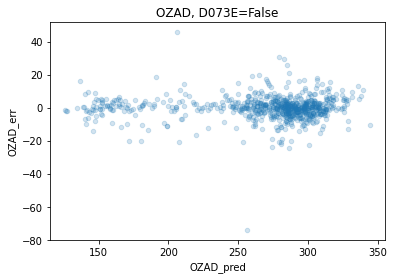

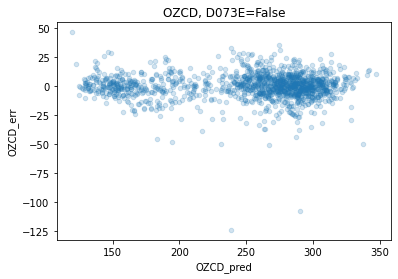

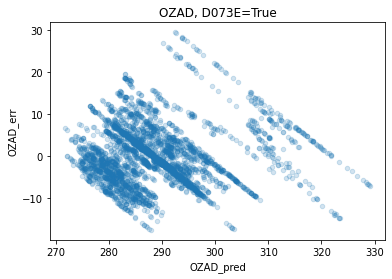

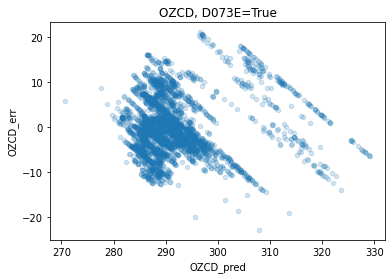

In [51]:
df_zenith["y_pred"] = np.nan
df_zenith["y_err"] = np.nan

for i_row, row in df_best_models.iterrows():
    print(row.target, row.D073E, row.interpolation_method)

    target_variable = f"{row.target}_{row.interpolation_method}"
    variables = [target_variable, *(row.predictors)]
    df_val = df_zenith[
        (df_zenith[f"tdiff_{row.target}"] < row.timediff_limit)
        & (df_zenith.zenith_angle < row.zenith_angle_limit)
        & (np.isin(df_zenith.index, index_val))
        & (df_zenith.D073E == row.D073E)
    ][variables].dropna()

    X_val = df_val[row.predictors]
    y_val = df_val[target_variable]

    df_val[f"{row.target}_pred"] = row.model.predict(X_val)
    df_val[f"{row.target}_err"] = df_val[target_variable] - df_val[f"{row.target}_pred"]

    df_zenith.loc[df_val.index, f"{row.target}_pred"] = df_val[f"{row.target}_pred"]
    df_zenith.loc[df_val.index, f"{row.target}_err"] = df_val[f"{row.target}_err"]

    df_val.plot.scatter(f"{row.target}_pred", f"{row.target}_err", alpha=0.2)
    plt.title(f"{row.target}, D073E={row.D073E}")

1. The manual data seems to fit pretty nicely, except for the outliers.
2. The auto data looks like it has non-random errors remaining. This could be due to the fact that the sample rate is very high compared to the rate of change of the ozone amount.
3. There could be some systematic bias in the result for auto as a result. Ideally, the 'tracks' would be parallel to the y axis.
4. I wonder if we should be taking a sub-sample of the auto data in the fit so that the errors are less correlated.

## Anomalies

Let's find the biggest errors and see if we can filter them out.

To me, the most intuitive way to do this is to make a simple model then eliminate those points that fit very poorly.
I have also tried filtering based on the time series, but this has been less successful.

Also, anomalous points show a large difference between the wavelengths.

<AxesSubplot:xlabel='dt'>

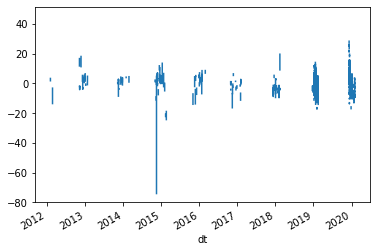

In [52]:
df_zenith.OZAD_err.plot()

<AxesSubplot:xlabel='dt'>

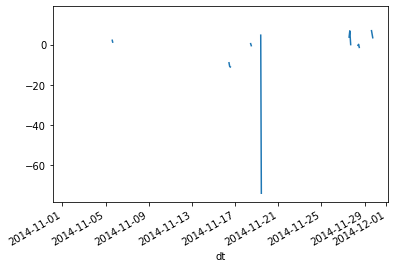

In [53]:
df_zenith.loc["2014-11"]["OZAD_err"].plot()

<AxesSubplot:xlabel='dt'>

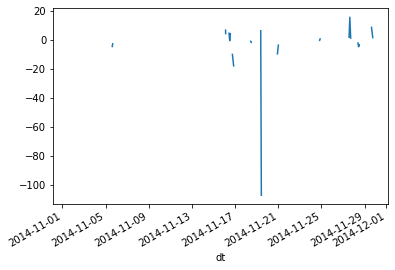

In [54]:
df_zenith.loc["2014-11"]["OZCD_err"].plot()

In [55]:
df_zenith.loc["2014-11-19"][["L(C)", "L(D)", "OZCD_err"]]

,L(C),L(D),OZCD_err
dt,,,
2014-11-19 03:17:22,0.89704,0.38969,NaN
2014-11-19 05:10:04,0.64032,0.24470,NaN
2014-11-19 06:09:57,0.50732,0.17488,NaN
2014-11-19 07:06:26,0.42543,0.13798,NaN
2014-11-19 08:07:26,0.33880,0.09106,NaN
2014-11-19 09:03:27,0.27800,0.05869,6.192383
2014-11-19 10:24:57,0.52143,0.34838,-107.368291
2014-11-19 10:30:20,0.23740,0.04458,NaN
2014-11-19 12:00:47,0.20460,0.02798,NaN


How can we remove this error? I think it should be possible just to identify the jump in the L(D) value.

In [56]:
# A little bit of hand tuning went into this.
# It is important that this is applied separately to the different instruments.
def diff_filter(_df, k=5):
    d = (_df.diff() / _df.index.to_series().diff().dt.total_seconds()).shift(-1)
    dev = (d - d.rolling(k).mean()).abs() / d.std()
    return dev

<AxesSubplot:xlabel='dt'>

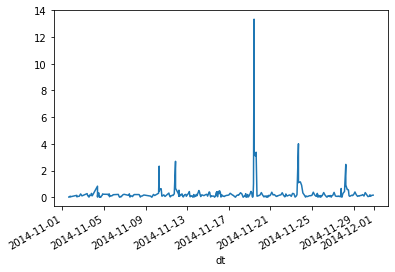

In [57]:
df_zenith[~df_zenith.D073E].loc["2014-11"]["L(D)"].pipe(diff_filter).plot()

<AxesSubplot:>

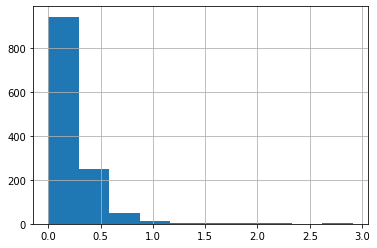

In [58]:
df_zenith[~df_zenith.D073E]["nA_m_nD_o_mu"].pipe(diff_filter).hist()

In [59]:
# Fill it with NaN if it doesn't pass the cut.
def diff_filter_nan(_s, k=5, threshold=2):
    d = (_s.diff() / _s.index.to_series().diff().dt.total_seconds()).shift(-1)
    dev = (d - d.rolling(k).mean()).abs() / d.std()
    return _s.where(dev < threshold)

OZAD False linear
['nA_m_nD_o_mu', 'mu', 'L(D)']
OZCD False linear
['nC_m_nD_o_mu', 'mu', 'L(D)', 'L(C)']
OZAD True linear_wsmooth
['nA_m_nD_o_mu', 'mu', 'L(D)', 'L(A)']
OZCD True linear_wsmooth
['nC_m_nD_o_mu', 'mu', 'L(D)', 'L(C)']


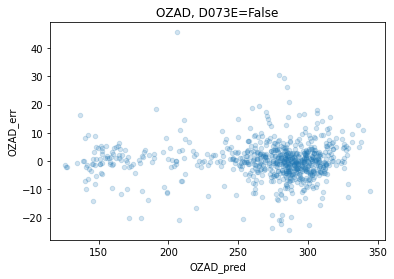

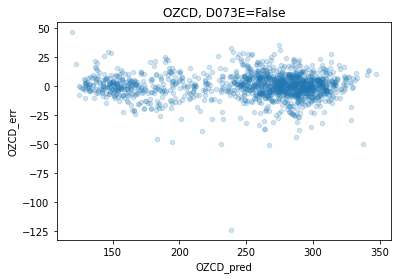

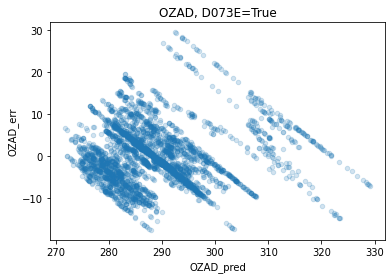

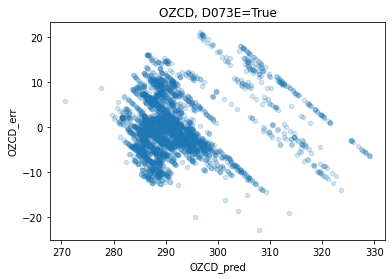

In [60]:
for target in ["OZAD", "OZCD"]:
    df_zenith[f"{target}_pred"] = np.nan
    df_zenith[f"{target}_err"] = np.nan

for i_row, row in df_best_models.iterrows():
    print(row.target, row.D073E, row.interpolation_method)
    print(row.predictors)

    target_variable = f"{row.target}_{row.interpolation_method}"
    variables = [target_variable, *(row.predictors)]
    df_val = df_zenith[
        (df_zenith[f"tdiff_{row.target}"] < row.timediff_limit)
        & (df_zenith.zenith_angle < row.zenith_angle_limit)
        & (df_zenith.D073E == row.D073E)
    ][variables].dropna()

    for var in [
        "L(D)",
        "L(A)",
        "L(C)",
    ]:
        if var in df_val:
            df_val[var] = df_val[var].pipe(diff_filter_nan)

    df_val = df_val[
        (np.isin(df_val.index, index_val))
    ]  # need to do this AFTER the diff filter
    df_val = df_val.dropna()

    #     print(df_val[variables].pipe(diff_filter_multi).dropna().shape)

    X_val = df_val[row.predictors]
    y_val = df_val[target_variable]

    df_val[f"{row.target}_pred"] = row.model.predict(X_val)
    df_val[f"{row.target}_err"] = df_val[target_variable] - df_val[f"{row.target}_pred"]

    df_zenith.loc[df_val.index, f"{row.target}_pred"] = df_val[f"{row.target}_pred"]
    df_zenith.loc[df_val.index, f"{row.target}_err"] = df_val[f"{row.target}_err"]

    df_zenith.loc[df_val.index].plot.scatter(
        f"{row.target}_pred", f"{row.target}_err", alpha=0.2
    )
    plt.title(f"{row.target}, D073E={row.D073E}")

That seems to have taken care of some of the worst anomalies, especially in AD manual.

There remain some big errors in CD manual, I think these are something to do with the target values.

There some cases where the interpolated values for AD and CD will disagree by a large number of Dobson units, even though both have a direct measurement within 24 hours.

In [61]:
df_zenith["interp_disagree"] = (df_zenith.OZAD_linear - df_zenith.OZCD_linear).abs()
df_zenith["interp_disagree_w"] = (
    df_zenith.OZAD_linear_wsmooth - df_zenith.OZCD_linear_wsmooth
).abs()
df_zenith["interp_disagree_d"] = (
    df_zenith.OZAD_linear_smooth - df_zenith.OZCD_linear_smooth
).abs()

<AxesSubplot:xlabel='interp_disagree', ylabel='OZCD_err'>

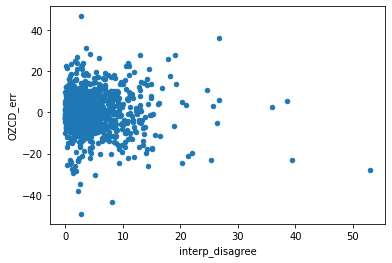

In [62]:
df_zenith[
    (df_zenith.tdiff_OZAD < 24) & ((df_zenith.tdiff_OZCD < 24)) & (~df_zenith.D073E)
].plot.scatter("interp_disagree", "OZCD_err")

<AxesSubplot:xlabel='interp_disagree', ylabel='OZAD_err'>

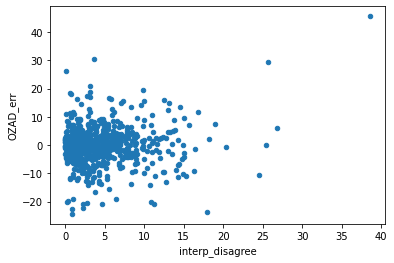

In [63]:
df_zenith[
    (df_zenith.tdiff_OZAD < 24) & ((df_zenith.tdiff_OZCD < 24)) & (~df_zenith.D073E)
].plot.scatter("interp_disagree", "OZAD_err")

In [64]:
def interp_disagree_filter(df, interpolation_method):
    return df.where(
        (df[f"OZAD_{interpolation_method}"] - df[f"OZCD_{interpolation_method}"]).abs()
        < 20
    )

OZAD False linear
['nA_m_nD_o_mu', 'mu', 'L(D)']
OZCD False linear
['nC_m_nD_o_mu', 'mu', 'L(D)', 'L(C)']
OZAD True linear_wsmooth
['nA_m_nD_o_mu', 'mu', 'L(D)', 'L(A)']
OZCD True linear_wsmooth
['nC_m_nD_o_mu', 'mu', 'L(D)', 'L(C)']


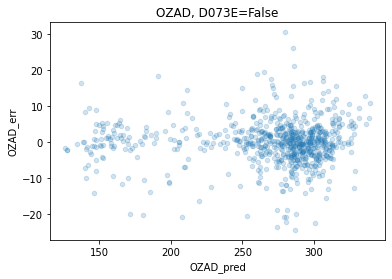

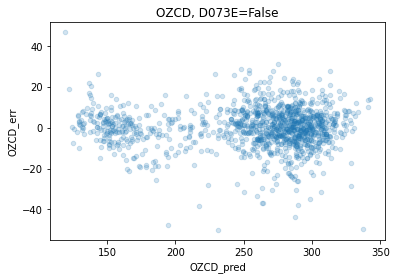

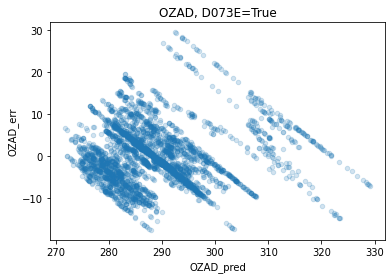

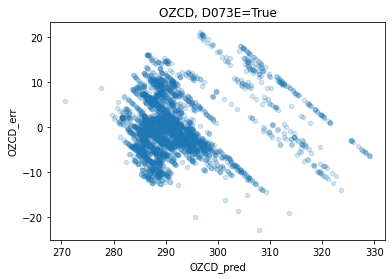

In [65]:
for target in ["OZAD", "OZCD"]:
    df_zenith[f"{target}_pred"] = np.nan
    df_zenith[f"{target}_err"] = np.nan

for i_row, row in df_best_models.iterrows():
    print(row.target, row.D073E, row.interpolation_method)
    print(row.predictors)

    target_variable = f"{row.target}_{row.interpolation_method}"
    variables = [target_variable, *(row.predictors)]
    df_val = df_zenith
    df_val = df_val.pipe(interp_disagree_filter, row.interpolation_method)
    df_val = df_val[
        (df_val[f"tdiff_{row.target}"] < row.timediff_limit)
        & (df_val.zenith_angle < row.zenith_angle_limit)
        & (df_val.D073E == row.D073E)
    ][variables].dropna()

    for var in [
        "L(D)",
        "L(A)",
        "L(C)",
    ]:
        if var in df_val:
            df_val[var] = df_val[var].pipe(diff_filter_nan)

    df_val = df_val[
        (np.isin(df_val.index, index_val))
    ]  # need to do this AFTER the diff filter
    df_val = df_val.dropna()

    #     print(df_val[variables].pipe(diff_filter_multi).dropna().shape)

    X_val = df_val[row.predictors]
    y_val = df_val[target_variable]

    df_val[f"{row.target}_pred"] = row.model.predict(X_val)
    df_val[f"{row.target}_err"] = df_val[target_variable] - df_val[f"{row.target}_pred"]

    df_zenith.loc[df_val.index, f"{row.target}_pred"] = df_val[f"{row.target}_pred"]
    df_zenith.loc[df_val.index, f"{row.target}_err"] = df_val[f"{row.target}_err"]

    df_zenith.loc[df_val.index].plot.scatter(
        f"{row.target}_pred", f"{row.target}_err", alpha=0.2
    )
    plt.title(f"{row.target}, D073E={row.D073E}")

## Autocorrelation
In both cases, the data are autocorrelated.
The auto data is sampled at high frequency, so it is especially noticeable.

In [66]:
df_zenith[~df_zenith.D073E]["L(A)"].autocorr()

0.7774551743429744

In [67]:
df_zenith[df_zenith.D073E]["L(A)"].autocorr()

0.9992319300693989

In [68]:
df_zenith[df_zenith.D073E].groupby([df_zenith.index.to_series().dt.floor("d")]).sample(
    5
)["L(A)"].autocorr()

0.35615628357203316

In [69]:
df_zenith[~df_zenith.D073E].groupby([df_zenith.index.to_series().dt.floor("d")]).sample(
    1
)["L(A)"].autocorr()

0.5212617112957493

In [70]:
def sample_maxn(_df, n_samples=3):
    if _df.shape[0] > n_samples:
        return _df.sample(n_samples)
    else:
        return _df.sample(_df.shape[0])

OZAD False linear
['nA_m_nD_o_mu', 'mu', 'L(D)']
OZCD False linear
['nC_m_nD_o_mu', 'mu', 'L(D)', 'L(C)']
OZAD True linear_wsmooth
['nA_m_nD_o_mu', 'mu', 'L(D)', 'L(A)']
OZCD True linear_wsmooth
['nC_m_nD_o_mu', 'mu', 'L(D)', 'L(C)']


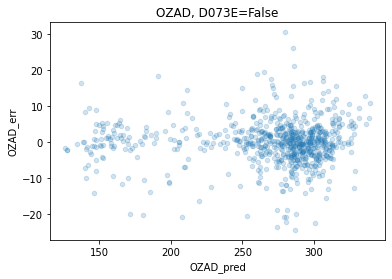

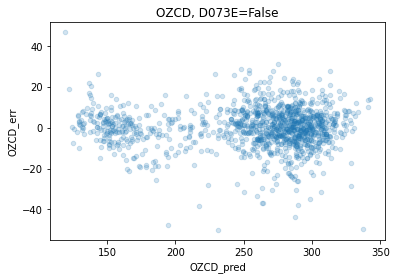

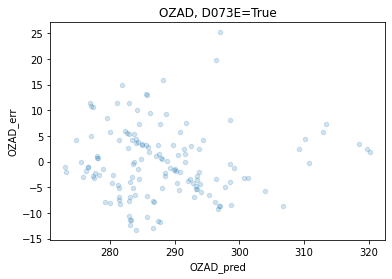

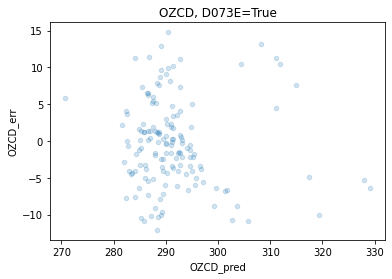

In [71]:
for target in ["OZAD", "OZCD"]:
    df_zenith[f"{target}_pred"] = np.nan
    df_zenith[f"{target}_err"] = np.nan

for i_row, row in df_best_models.iterrows():
    print(row.target, row.D073E, row.interpolation_method)
    print(row.predictors)

    target_variable = f"{row.target}_{row.interpolation_method}"
    variables = [target_variable, *(row.predictors)]
    df_val = df_zenith
    df_val = df_val.pipe(interp_disagree_filter, row.interpolation_method)
    df_val = df_val[
        (df_val[f"tdiff_{row.target}"] < row.timediff_limit)
        & (df_val.zenith_angle < row.zenith_angle_limit)
        & (df_val.D073E == row.D073E)
    ][variables].dropna()

    for var in [
        "L(D)",
        "L(A)",
        "L(C)",
    ]:
        if var in df_val:
            df_val[var] = df_val[var].pipe(diff_filter_nan)

    df_val = df_val[
        (np.isin(df_val.index, index_val))
    ]  # need to do this AFTER the diff filter
    df_val = df_val.dropna()

    # Only take a small number of random points per day
    if row.D073E:
        df_val = df_val.groupby(df_val.index.to_series().dt.floor("d")).sample(2)

    #     print(df_val[variables].pipe(diff_filter_multi).dropna().shape)

    X_val = df_val[row.predictors]
    y_val = df_val[target_variable]

    df_val[f"{row.target}_pred"] = row.model.predict(X_val)
    df_val[f"{row.target}_err"] = df_val[target_variable] - df_val[f"{row.target}_pred"]

    df_zenith.loc[df_val.index, f"{row.target}_pred"] = df_val[f"{row.target}_pred"]
    df_zenith.loc[df_val.index, f"{row.target}_err"] = df_val[f"{row.target}_err"]

    df_zenith.loc[df_val.index].plot.scatter(
        f"{row.target}_pred", f"{row.target}_err", alpha=0.2
    )
    plt.title(f"{row.target}, D073E={row.D073E}")

## Fitting again with anomalies removed
Now, let's try fitting a model again again after filtering.

In [72]:
df_zenith_reduced = df_zenith

In [73]:
df_zenith_reduced = df_zenith_reduced.pipe(interp_disagree_filter, "linear")

In [74]:
# Train/validate/test split will be the same for all experiments.
# You need separate validation and test sets,
# or your model structure choice will be biased,
# leading to underestimation of the error in production.

test_size = 0.2
val_size = 0.2
random_state = 0

index_train, index_val = train_test_split(
    df_zenith.index, test_size=0.2, random_state=random_state
)


# For now, I will give it just the 'ideal' variable.
variable_dict = {
    "CD": [
        [
            "nC_m_nD_o_mu",
        ],
        [
            "nC_m_nD_o_mu",
            "mu",
        ],
        ["nC_m_nD_o_mu", "L(C)"],
        ["nC_m_nD_o_mu", "L(D)"],
        ["nC_m_nD_o_mu", "mu", "L(C)"],
        ["nC_m_nD_o_mu", "mu", "L(D)"],
        ["nC_m_nD_o_mu", "mu", "L(D)", "L(C)"],
    ],
    "AD": [
        [
            "nA_m_nD_o_mu",
        ],
        ["nA_m_nD_o_mu", "mu"],
        ["nA_m_nD_o_mu", "L(A)"],
        ["nA_m_nD_o_mu", "L(D)"],
        ["nA_m_nD_o_mu", "mu", "L(A)"],
        ["nA_m_nD_o_mu", "mu", "L(D)"],
        ["nA_m_nD_o_mu", "mu", "L(D)", "L(A)"],
    ],
}

# Experiment with different interpolation methods
# interpolation_method_list = ["linear", "nearest", "cubic_smooth", "linear_smooth"]
interpolation_method_list = [
    "nearest",
    "linear",
    "linear_smooth",
    "linear_wsmooth",
    "cubic_smooth",
    "cubic_wsmooth",
]

# Experiment with placing limits on the time difference between
# the zenith measurement and the direct sun measurement.
# Restricting this will make the model fit better, but then you are implicitly limiting mu as well.
timediff_limit_list = [24]  # [1, 2, 3, 4, 8, 12, 24]  # these are in hours

# Experiment with limiting the zenith angle range.
# We don't actually want to reduce this range, because we want our predictions to be a good fit at all values of mu.
zenith_angle_limit_array = [90]  # np.arange(60, 90, 2.5)

# Experiment with different model structures
model_structure_list = [
    # Dummy that just predicts the mean, for assessing performance.
    #     make_pipeline(DummyRegressor()),
    # Standard linear regression
    make_pipeline(LinearRegression()),
    # Interaction terms only
    make_pipeline(
        PolynomialFeatures(interaction_only=True), StandardScaler(), LinearRegression()
    ),
    # Polynomial terms O(2)
    make_pipeline(PolynomialFeatures(2), StandardScaler(), LinearRegression()),
    # Polynomial terms O(3)
    make_pipeline(PolynomialFeatures(3), StandardScaler(), LinearRegression()),
    # Shallow artificial neural network - watch out this is comparatively slow to train and will certainly overfit.
    #     make_pipeline(StandardScaler(), MLPRegressor(max_iter=3000)),
]

results = []

# Loop over AD/CD
for wl, predictor_list in variable_dict.items():
    target = f"OZ{wl}"
    print(target)
    # How many models are we training?
    number_of_models = functools.reduce(
        operator.mul,
        map(
            len,
            [
                [True, False],
                predictor_list,
                timediff_limit_list,
                interpolation_method_list,
                model_structure_list,
                zenith_angle_limit_array,
            ],
        ),
        1,
    )

    # Loop over model configurations
    for (
        use_D073E,
        predictors,
        timediff_limit,
        interpolation_method,
        model,
        zenith_angle_limit,
    ) in tqdm(  # progress bar
        itertools.product(  # all combinations of model config
            [True, False],
            predictor_list,
            timediff_limit_list,
            interpolation_method_list,
            model_structure_list,
            zenith_angle_limit_array,
        ),
        total=number_of_models,
    ):

        # Set variable names
        target_variable = f"{target}_{interpolation_method}"
        variables = [target_variable, *predictors]

        df_reduced = df_zenith[
            (df_zenith[f"tdiff_{target}"] < timediff_limit)
            & (df_zenith.zenith_angle < zenith_angle_limit)
            & (df_zenith.D073E == use_D073E)
        ]
        df_reduced = df_reduced.pipe(interp_disagree_filter, interpolation_method)

        for var in [
            "L(D)",
            "L(A)",
            "L(C)",
        ]:
            if var in df_reduced:
                df_reduced[var] = df_reduced[var].pipe(diff_filter_nan)

        # Subset zenith data to just variables of interest,
        # and select only data within a reasonable time of
        # the last direct measurement.
        # Also drop NaN values.
        df_train = df_reduced[
            (np.isin(df_reduced.index, index_train))  # TODO this is inefficient
        ][variables].dropna()

        df_val = df_reduced[
            (np.isin(df_reduced.index, index_val))  # TODO this is inefficient
        ][variables].dropna()

        X_train = df_train[predictors]
        y_train = df_train[target_variable]
        X_val = df_val[predictors]
        y_val = df_val[target_variable]

        # Train the model
        # print(model)
        model.fit(X_train, y_train)

        # Get the error score
        y_val_predict = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_val_predict, squared=False)
        maxe = max_error(y_val, y_val_predict)

        # Get the R^2 score
        r2 = model.score(X_val, y_val)

        # Get the AIC
        k = model.steps[-1][1].n_features_in_
        AIC = 2 * k - 2 * np.log(np.sum((y_val_predict - y_val) ** 2))

        # Save the results
        results.append(
            {
                "rmse": rmse,
                "standard_error": rmse / np.sqrt(df_val.shape[0]),
                "maxe": maxe,
                "r2": r2,
                "target": target,
                "D073E": use_D073E,
                "predictors": predictors,
                "predictors_str": str(predictors),
                "set_size": df_train.shape[0],
                "val_size": df_val.shape[0],
                "timediff_limit": timediff_limit,
                "zenith_angle_limit": zenith_angle_limit,
                "interpolation_method": interpolation_method,
                "model": deepcopy(model),
                "model_str": str(model),
                "k": k,
                "AIC": AIC,
            }
        )

# We can now make a dataframe of our results...
df_results = pd.DataFrame(results)

OZCD


  0%|          | 0/336 [00:00<?, ?it/s]

OZAD


  0%|          | 0/336 [00:00<?, ?it/s]

In [75]:
pd.options.display.max_colwidth = (
    1000  # the model __repr__ string ends up being quite long
)
df_best_models = df_results.groupby(
    [
        "D073E",
        "target",
    ]
).apply(lambda df: df.iloc[df["standard_error"].argmin()])
df_best_models[["model_str", "predictors", "interpolation_method", "rmse", "r2"]]

model_str  \
D073E target                                                                                                                                                                                             
False OZAD    Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),\n                ('standardscaler', StandardScaler()),\n                ('linearregression', LinearRegression())])   
      OZCD    Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),\n                ('standardscaler', StandardScaler()),\n                ('linearregression', LinearRegression())])   
True  OZAD    Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),\n                ('standardscaler', StandardScaler()),\n                ('linearregression', LinearRegression())])   
      OZCD    Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),\n                ('standardscaler', StandardScaler()),\n                ('linearregression', LinearRegression())])   

                                  predictors interpolation_method       rmse  \
D073E target                                                                   
False OZAD                [nA_m_nD_o_mu, mu]               linear   8.458749   
      OZCD    [nC_m_nD_o_mu, mu, L(D), L(C)]               linear  10.163143   
True  OZAD    [nA_m_nD_o_mu, mu, L(D), L(A)]       linear_wsmooth   6.677855   
      OZCD    [nC_m_nD_o_mu, mu, L(D), L(C)]       linear_wsmooth   6.194496   

                    r2  
D073E target            
False OZAD    0.968866  
      OZCD    0.961244  
True  OZAD    0.660167  
      OZCD    0.578926

OZAD False linear
['nA_m_nD_o_mu', 'mu']
OZCD False linear
['nC_m_nD_o_mu', 'mu', 'L(D)', 'L(C)']
OZAD True linear_wsmooth
['nA_m_nD_o_mu', 'mu', 'L(D)', 'L(A)']
OZCD True linear_wsmooth
['nC_m_nD_o_mu', 'mu', 'L(D)', 'L(C)']


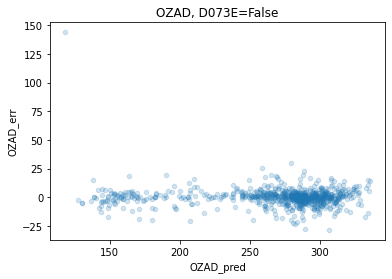

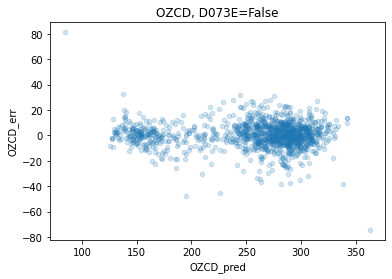

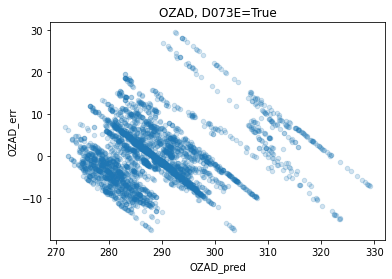

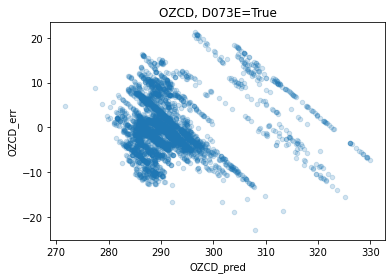

In [76]:
for target in ["OZAD", "OZCD"]:
    df_zenith[f"{target}_pred"] = np.nan
    df_zenith[f"{target}_err"] = np.nan

for i_row, row in df_best_models.iterrows():
    print(row.target, row.D073E, row.interpolation_method)
    print(row.predictors)

    target_variable = f"{row.target}_{row.interpolation_method}"
    variables = [target_variable, *(row.predictors)]
    df_val = df_zenith
    df_val = df_val.pipe(interp_disagree_filter, row.interpolation_method)
    df_val = df_val[
        (df_val[f"tdiff_{row.target}"] < row.timediff_limit)
        & (df_val.zenith_angle < row.zenith_angle_limit)
        & (df_val.D073E == row.D073E)
    ][variables].dropna()

    for var in [
        "L(D)",
        "L(A)",
        "L(C)",
    ]:
        if var in df_val:
            df_val[var] = df_val[var].pipe(diff_filter_nan)

    df_val = df_val[
        (np.isin(df_val.index, index_val))
    ]  # need to do this AFTER the diff filter
    df_val = df_val.dropna()

    # Only take a small number of random points per day
    # To some extent this is just hiding the problem. The autocorrelation is still there in the data!
    #     if row.D073E:
    #         df_val = df_val.groupby(df_val.index.to_series().dt.floor('d')).sample(2)

    #     print(df_val[variables].pipe(diff_filter_multi).dropna().shape)

    X_val = df_val[row.predictors]
    y_val = df_val[target_variable]

    df_val[f"{row.target}_pred"] = row.model.predict(X_val)
    df_val[f"{row.target}_err"] = df_val[target_variable] - df_val[f"{row.target}_pred"]

    df_zenith.loc[df_val.index, f"{row.target}_pred"] = df_val[f"{row.target}_pred"]
    df_zenith.loc[df_val.index, f"{row.target}_err"] = df_val[f"{row.target}_err"]

    df_zenith.loc[df_val.index].plot.scatter(
        f"{row.target}_pred", f"{row.target}_err", alpha=0.2
    )
    plt.title(f"{row.target}, D073E={row.D073E}")

In [77]:
# df_best_models.iloc[0].model
# this produces an sklearn model object, with a predict method.
# df_zenith[df_best_models.iloc[0].predictors]
df_best_models.iloc[0].model.predict(
    df_zenith[df_zenith.D073E == False][df_best_models.iloc[0].predictors].dropna()
)
# df_best_models.iloc[0]

array([271.84998173, 275.71716054, 267.61973907, ..., 323.54487484,
       299.32353508, 297.22579881])

There are still some big outliers, so that's something to keep working on.

The autocorrelation is still there, as you would expect (you can still hide it by subsampling, and subsampling was used in the fit.)

## Oscillations

First, let's get model predictions for the whole dataset, not just the validation sample.

In [78]:
for target in ["OZAD", "OZCD"]:
    df_zenith[f"{target}_pred"] = np.nan
    df_zenith[f"{target}_err"] = np.nan

for i_row, row in df_best_models.iterrows():
    print(row.target, row.D073E, row.interpolation_method)
    print(row.predictors)

    target_variable = f"{row.target}_{row.interpolation_method}"
    variables = [target_variable, *(row.predictors)]
    df_val = df_zenith
    df_val = df_val.pipe(interp_disagree_filter, row.interpolation_method)
    df_val = df_val[
        (df_val[f"tdiff_{row.target}"] < row.timediff_limit)
        & (df_val.zenith_angle < row.zenith_angle_limit)
        & (df_val.D073E == row.D073E)
    ][variables].dropna()

    for var in [
        "L(D)",
        "L(A)",
        "L(C)",
    ]:
        if var in df_val:
            df_val[var] = df_val[var].pipe(diff_filter_nan)

    #     df_val = df_val[(np.isin(df_val.index, index_val))] # need to do this AFTER the diff filter
    df_val = df_val.dropna()

    # Only take a small number of random points per day
    # To some extent this is just hiding the problem. The autocorrelation is still there in the data!
    #     if row.D073E:
    #         df_val = df_val.groupby(df_val.index.to_series().dt.floor('d')).sample(2)

    #     print(df_val[variables].pipe(diff_filter_multi).dropna().shape)

    X_val = df_val[row.predictors]
    y_val = df_val[target_variable]

    df_val[f"{row.target}_pred"] = row.model.predict(X_val)
    df_val[f"{row.target}_err"] = df_val[target_variable] - df_val[f"{row.target}_pred"]

    df_zenith.loc[df_val.index, f"{row.target}_pred"] = df_val[f"{row.target}_pred"]
    df_zenith.loc[df_val.index, f"{row.target}_err"] = df_val[f"{row.target}_err"]


OZAD False linear
['nA_m_nD_o_mu', 'mu']
OZCD False linear
['nC_m_nD_o_mu', 'mu', 'L(D)', 'L(C)']
OZAD True linear_wsmooth
['nA_m_nD_o_mu', 'mu', 'L(D)', 'L(A)']
OZCD True linear_wsmooth
['nC_m_nD_o_mu', 'mu', 'L(D)', 'L(C)']


<AxesSubplot:xlabel='dt'>

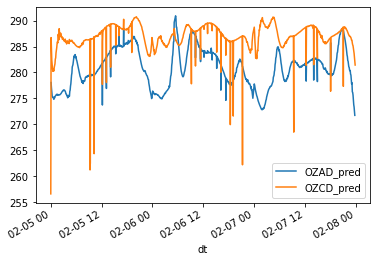

In [79]:
df_zenith.loc["2019-02-05":"2019-02-07"][["OZAD_pred", "OZCD_pred"]].plot()

You will see discontinuities in the predictions: these are because of the two instruments.
During this period, the manual measurements seem to be systematically lower, and the AD predictions also seem to be systematically lower.

Let's see if that is borne out on average...

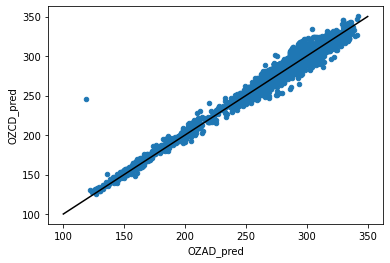

In [80]:
df_zenith.plot.scatter("OZAD_pred", "OZCD_pred")
plt.plot([100, 350], [100, 350], c="k")

(-50.0, 50.0)

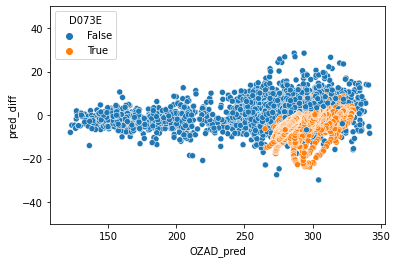

In [81]:
sns.scatterplot(
    data=df_zenith.assign(pred_diff=df_zenith.OZAD_pred - df_zenith.OZCD_pred),
    x="OZAD_pred",
    y="pred_diff",
    hue="D073E",
)
plt.ylim(-50, 50)

Unfortunately, there does look to be some systematic effect. The AD predictions tend to be lower than the CD predictions at low ozone values.

Ideally it should be unbiased like the direct measurements.

(-50.0, 50.0)

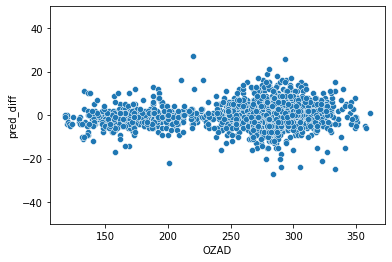

In [82]:
sns.scatterplot(
    data=df_direct.assign(pred_diff=df_direct.OZAD - df_direct.OZCD),
    x="OZAD",
    y="pred_diff",
)
plt.ylim(-50, 50)

It's harder to do the same thing for auto vs manual because they are not the same line in the dataframe.

Is there a systematic bias due to the time of day?

In [83]:
df_zenith["hour"] = df_zenith.index.hour

<AxesSubplot:xlabel='hour', ylabel='OZAD_err'>

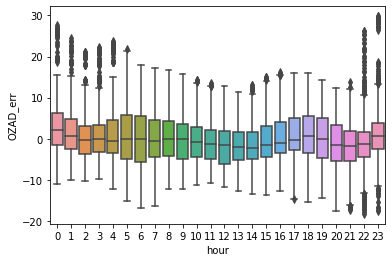

In [84]:
sns.boxplot(data=df_zenith[df_zenith.D073E], x="hour", y="OZAD_err")

(-50.0, 50.0)

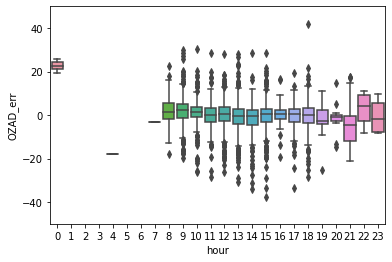

In [85]:
sns.boxplot(data=df_zenith[(~df_zenith.D073E)], x="hour", y="OZAD_err")
plt.ylim(-50, 50)

It looks like manual measurements taken close to midnight are high? This might only be a small number of measurements...

(-50.0, 50.0)

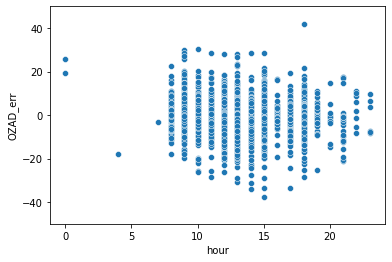

In [86]:
sns.scatterplot(
    data=df_zenith[(~df_zenith.D073E)],
    x="hour",
    y="OZAD_err",
)
plt.ylim(-50, 50)

Yes, there are only a small number of measurements at those hours. I think they also have high mu.

In [87]:
df_zenith["spring"] = np.in1d(df_zenith.index.month, [8, 9, 10])
df_zenith["autumn"] = np.in1d(df_zenith.index.month, [2, 3, 4])

(-50.0, 50.0)

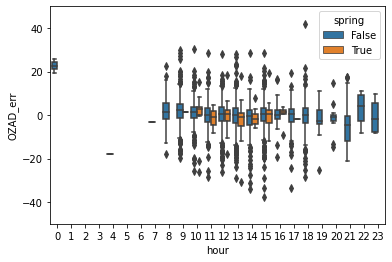

In [88]:
sns.boxplot(data=df_zenith[(~df_zenith.D073E)], x="hour", y="OZAD_err", hue="spring")
plt.ylim(-50, 50)

(-50.0, 50.0)

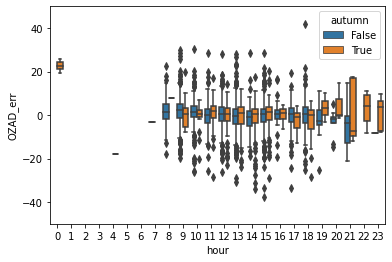

In [89]:
sns.boxplot(data=df_zenith[(~df_zenith.D073E)], x="hour", y="OZAD_err", hue="autumn")
plt.ylim(-50, 50)

(-50.0, 50.0)

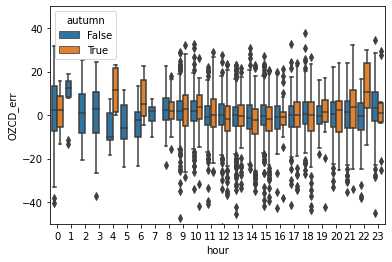

In [90]:
sns.boxplot(data=df_zenith[(~df_zenith.D073E)], x="hour", y="OZCD_err", hue="autumn")
plt.ylim(-50, 50)

Overall, there doesn't seem to be a consistent effect of the hour of the day on the predicted ozone value. Maybe this needs further investigation.